<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled249.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 727.0 kB/s eta 0:00:00
Mounted at /content/drive

Processing 3WU2 from /content/3WU2.cif ...


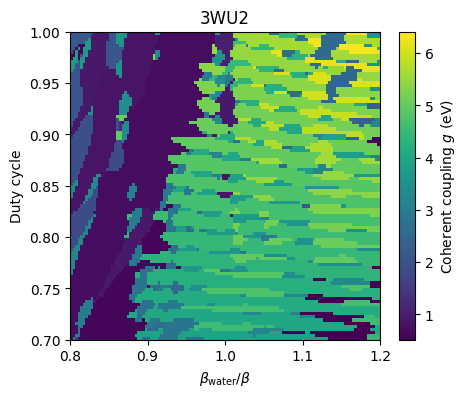


Processing 6W1U from /content/6W1U.cif ...


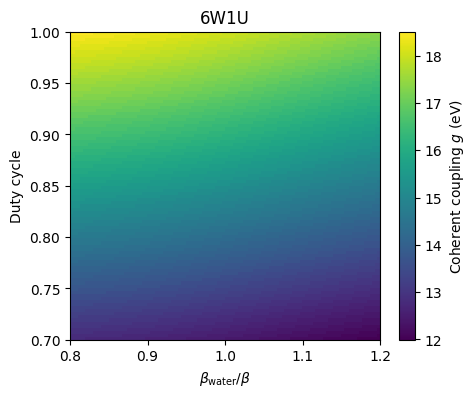


Processing 7RF1 from /content/7RF1.cif ...


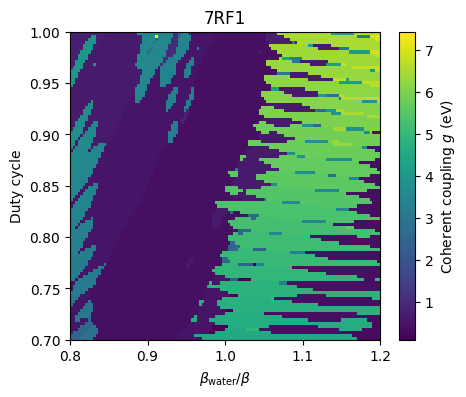


Processing 8F4C from /content/8F4C.cif ...


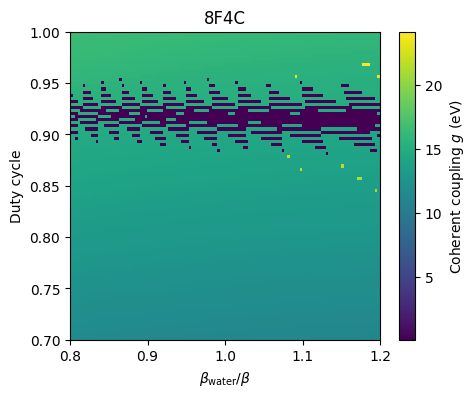


Processing 8F4D from /content/8F4D.cif ...


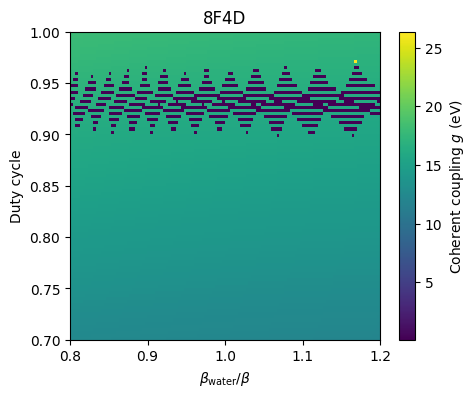


Processing 8F4E from /content/8F4E.cif ...


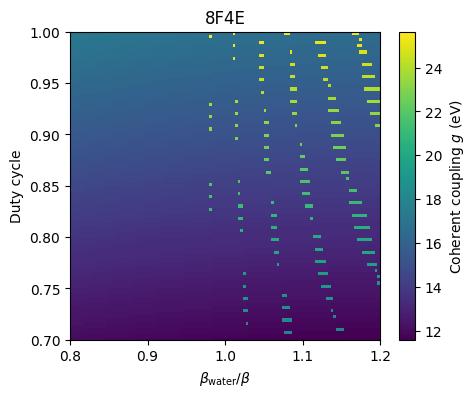


Processing 8F4F from /content/8F4F.cif ...


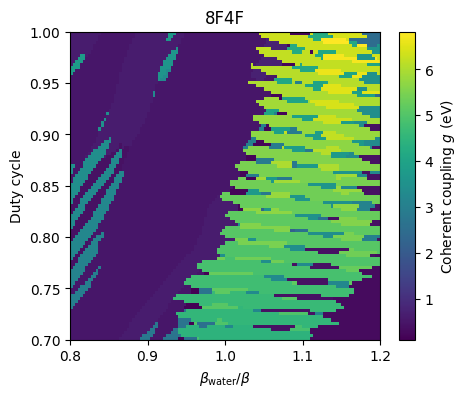


Processing 8F4G from /content/8F4G.cif ...


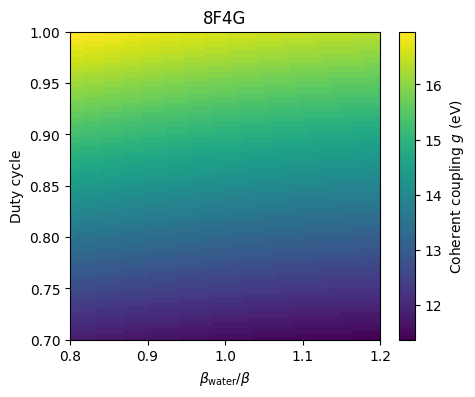


Processing 8F4H from /content/8F4H.cif ...


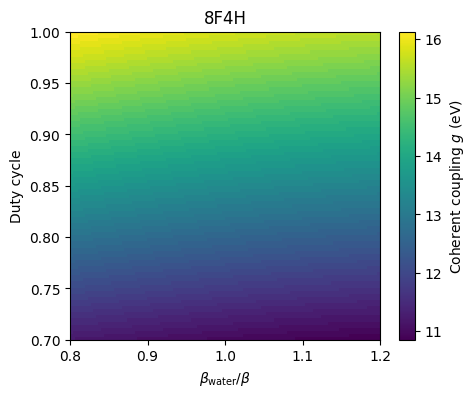


Processing 8F4I from /content/8F4I.cif ...


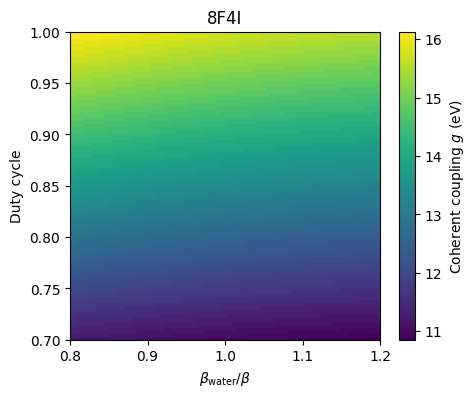


Processing 8F4J from /content/8F4J.cif ...


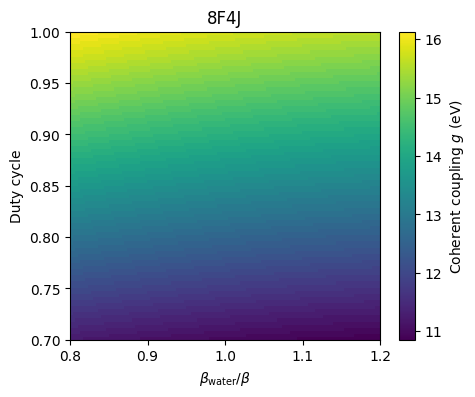


Processing 8F4K from /content/8F4K.cif ...


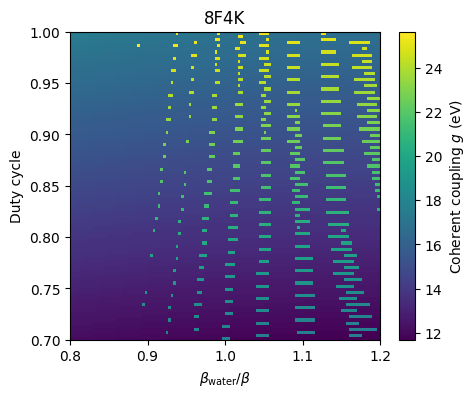


Global g range across all structures: 0.10339169241510007 to 26.36488156585052


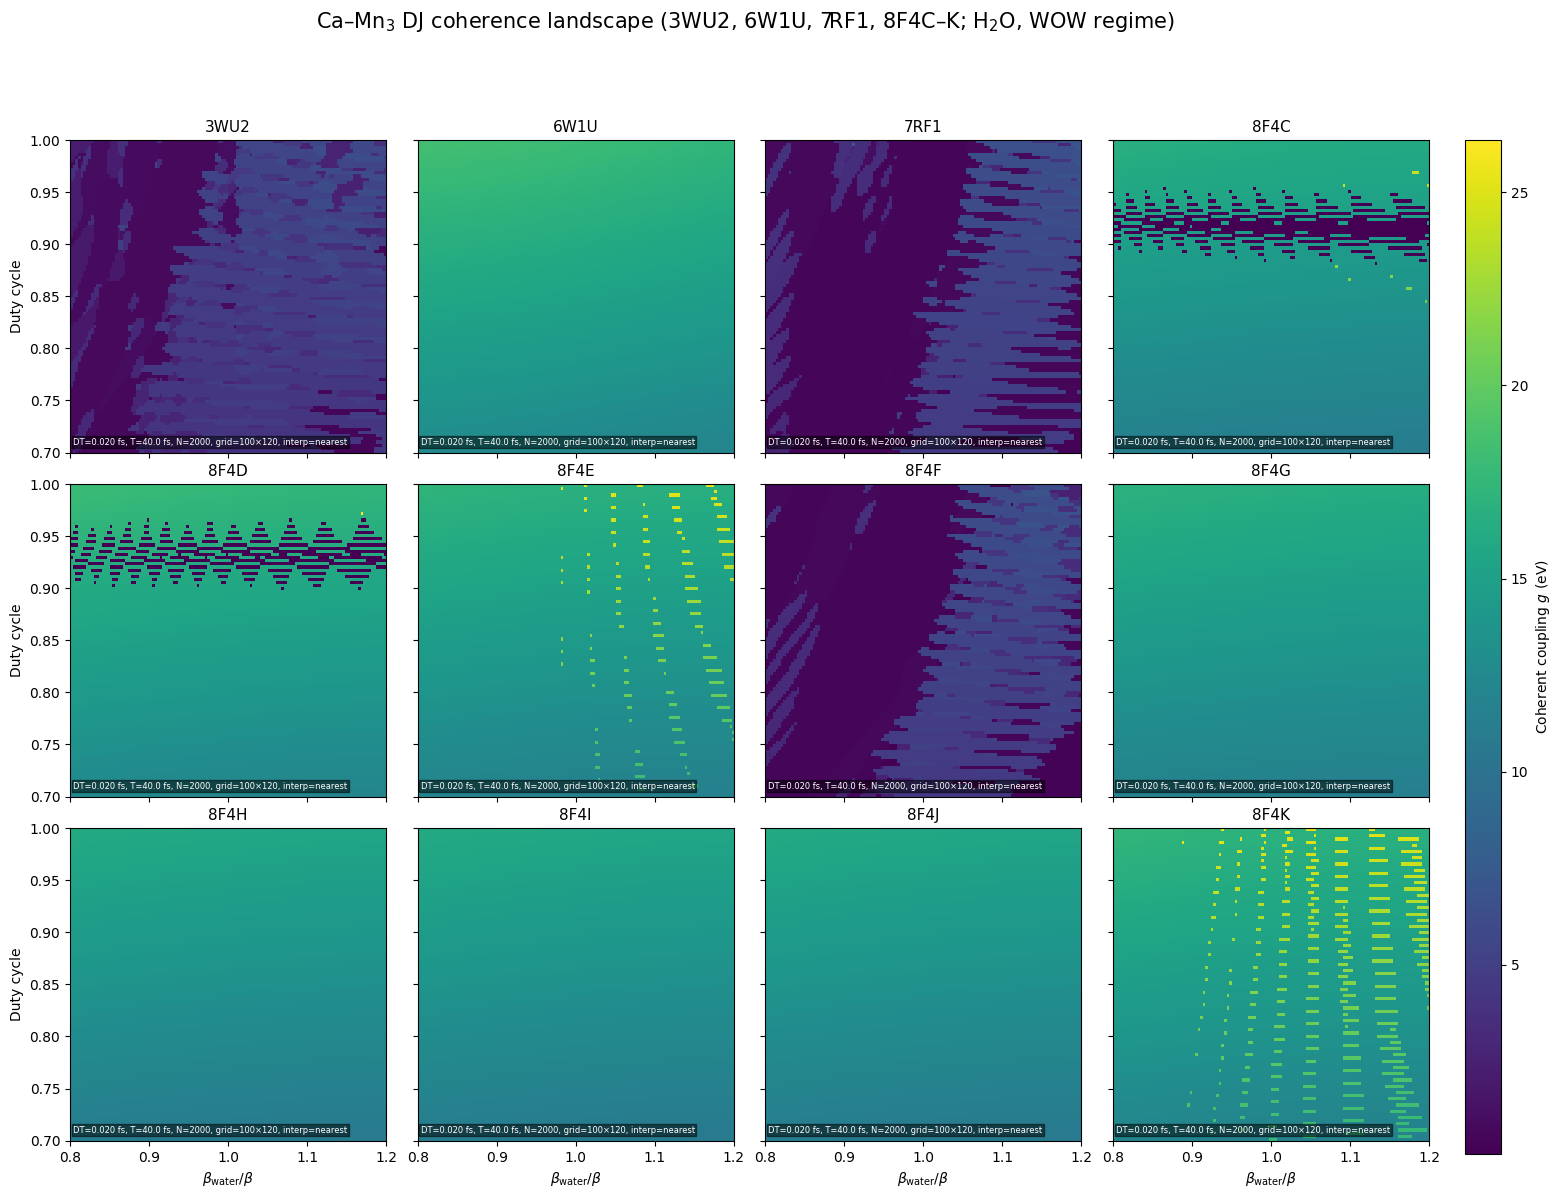


All outputs saved to:
  Content dir: /content/dj_maps
  Drive dir  : /content/drive/MyDrive/dj_maps
  Master NPZ : /content/dj_maps/DJ_all_structs_wow.npz
  Master PNG : /content/dj_maps/DJ_3x4_wow_nearest.png
  Master PDF : /content/dj_maps/DJ_3x4_wow_nearest.pdf


In [ ]:
# ============================================================
#  High-res 3×4 DJ Coherence Map (3WU2, 6W1U, 7RF1, 8F4C–K)
#  WOW REGIME, Nature-style (nearest interpolation)
# ============================================================

# --- 0) Install gemmi (for CIF handling) --------------------  # [001]
!pip install -q gemmi                                        # [002]

# --- 1) Mount Google Drive ---------------------------------  # [010]
from google.colab import drive                               # [011]
drive.mount("/content/drive")                                # [012]

# --- 2) Imports --------------------------------------------- # [020]
import math                                                  # [021]
import shutil                                                # [022]
from pathlib import Path                                     # [023]

import numpy as np                                           # [024]
import matplotlib.pyplot as plt                              # [025]
from scipy.linalg import expm                                # [026]
from scipy.optimize import curve_fit                         # [027]
from scipy.signal import hilbert                             # [028]

import gemmi                                                 # [029]

# --- 3) Global constants (WOW regime physics) --------------- # [040]
H_BAR        = 6.582119569e-16       # eV·s                   # [041]
H_BAR_EV_FS  = 6.582119569e-1        # eV·fs (≈0.6582)        # [042]
DT_FS        = 0.02                  # fs                     # [043]
DT_S         = DT_FS * 1e-15         # seconds                # [044]
TOTAL_FS     = 40.0                  # fs                     # [045]
N_STEPS      = int(TOTAL_FS / DT_FS)                         # [046]

T0           = 10.0                  # strong coupling        # [047]
BETA_E       = 1.0                   # base decay 1/Å         # [048]
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]                     # [049]
COMB_WIDTH   = 0.18                                             # [050]

# --- 4) Paths and structures -------------------------------- # [060]
CONTENT_ROOT = Path("/content")                               # [061]
DRIVE_ROOT   = Path("/content/drive/MyDrive")                 # [062]

CIF_DIR      = DRIVE_ROOT / "psii_cifs"                       # [063]
OUT_DIR_CT   = CONTENT_ROOT / "dj_maps"                       # [064]
OUT_DIR_DR   = DRIVE_ROOT / "dj_maps"                         # [065]

CIF_DIR.mkdir(parents=True, exist_ok=True)                    # [066]
OUT_DIR_CT.mkdir(parents=True, exist_ok=True)                 # [067]
OUT_DIR_DR.mkdir(parents=True, exist_ok=True)                 # [068]

# 12 structures: 3 reference + full 8F4C–K series             # [070]
STRUCTURES = [
    "3WU2", "6W1U", "7RF1",                                   # [071]
    "8F4C", "8F4D", "8F4E", "8F4F",                           # [072]
    "8F4G", "8F4H", "8F4I", "8F4J", "8F4K"                    # [073]
]

# High-res DJ grid                                             # [080]
duties = np.linspace(0.70, 1.00, 100)   # duty cycle          # [081]
betas  = np.linspace(0.80, 1.20, 120)   # beta_water/beta     # [082]
STAMP_TEXT = (                                             # [083]
    f"DT={DT_FS:.3f} fs, T={TOTAL_FS:.1f} fs, "            # [084]
    f"N={N_STEPS}, grid={len(duties)}×{len(betas)}, "      # [085]
    "interp=nearest"                                       # [086]
)                                                          # [087]
# --- 5) Geometry helpers ------------------------------------ # [090]
def _atom_iter(struct):
    for model in struct:
        for chain in model:
            for res in chain:
                for atom in res:
                    yield model, chain, res, atom

def _combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    idx = list(range(r))
    yield tuple(pool[i] for i in idx)
    while True:
        for i in reversed(range(r)):
            if idx[i] != i + n - r:
                break
        else:
            return
        idx[i] += 1
        for j in range(i + 1, r):
            idx[j] = idx[j - 1] + 1
        yield tuple(pool[i] for i in idx)

def read_structure_any(path):
    st = gemmi.read_structure(str(path))
    st.remove_alternative_conformations()
    st.merge_chain_parts()
    st.remove_empty_chains()
    return st

def get_psii_core_16(struct):
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []

    for _, _, res, atom in _atom_iter(struct):
        el   = atom.element.name.upper()
        resn = res.name.upper()
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z],
                        dtype=float)
        if el == "MN":
            mn_atoms.append((pos, res, atom))
        elif el == "CA":
            ca_atoms.append((pos, res, atom))
        elif el == "O":
            if resn in ("HOH", "WAT", "H2O", "DOD", "TIP3", "SOL"):
                water_oxy.append((pos, res, atom))
            else:
                oxy_atoms.append((pos, res, atom))

    if len(mn_atoms) < 4 or len(ca_atoms) == 0:
        raise RuntimeError("Not enough Mn/Ca atoms")

    mn_positions = np.array([p for (p, _, _) in mn_atoms])
    best_idx = None
    best_score = 1e9
    for idxs in _combinations(range(len(mn_positions)), 4):
        pts   = mn_positions[list(idxs)]
        c     = pts.mean(axis=0)
        score = np.sum(np.linalg.norm(pts - c, axis=1))
        if score < best_score:
            best_score = score
            best_idx   = idxs

    Mn_sel = [mn_atoms[i] for i in best_idx]
    Mn_pos = np.array([p for (p, _, _) in Mn_sel])

    c_mn   = Mn_pos.mean(axis=0)
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))
    Ca_pos = Ca_sel[0]

    # μ-oxo: O within 2.4 Å of two Mn
    mu_oxo = []
    for (pos, res, atom) in oxy_atoms:
        d = np.linalg.norm(Mn_pos - pos, axis=1)
        close_mn = np.where(d < 2.4)[0]
        if len(close_mn) >= 2:
            mu_oxo.append((pos, res, atom))
    if len(mu_oxo) < 5:
        raise RuntimeError("Not enough μ-oxo candidates")
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))
    OX_sel = mu_oxo[:5]
    OX_pos = np.array([p for (p, _, _) in OX_sel])

    # Waters: nearest 2 to Mn4Ca centroid
    cluster_center = np.vstack([Mn_pos, Ca_pos[None, :]]).mean(axis=0)
    if len(water_oxy) < 2:
        raise RuntimeError("Not enough waters")
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))
    W_sel = water_oxy[:2]
    W_pos = np.array([p for (p, _, _) in W_sel])

    coords = np.vstack([Mn_pos, Ca_pos[None, :], OX_pos, W_pos])
    extra_needed = 16 - coords.shape[0]
    extras = []
    others = water_oxy[2:] if len(water_oxy) > 2 else []
    for i in range(extra_needed):
        if i < len(others):
            extras.append(others[i][0])
        else:
            extras.append(W_pos[-1] + np.array([0.05 * (i + 1), 0.0, 0.0]))
    if extras:
        coords = np.vstack([coords, np.array(extras)])

    if coords.shape[0] != 16:
        raise RuntimeError("Core is not 16 sites")

    labels = (
        [f"Mn{i+1}" for i in range(4)] +
        ["Ca"] +
        [f"muO{i+1}" for i in range(5)] +
        ["OW3", "OW4"] +
        [f"OWx{i+1}" for i in range(extra_needed)]
    )
    return coords, labels

# --- 6) Hamiltonian + TDSE + g extraction -------------------# [240]
def resonance_comb(r):
    val = 0.0
    for c in COMB_CENTERS:
        val += math.exp(-(r - c) ** 2 / (2 * COMB_WIDTH ** 2))
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))

def build_hamiltonian(coords, duty, beta_scale_water):
    coords = np.asarray(coords, float)
    n = coords.shape[0]
    H = np.zeros((n, n), dtype=np.complex128)

    diag = np.array([
        2.0, 2.0, 2.0, 2.0,      # Mn
        0.7,                     # Ca
        1.0, 1.0, 1.0, 1.0, 1.0, # mu-oxo
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2  # waters
    ], dtype=float)
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    for i in range(n):
        for j in range(i + 1, n):
            r = R[i, j]
            beta = BETA_E
            if (i >= 10) or (j >= 10):
                beta = BETA_E * beta_scale_water
            Tij = T0 * math.exp(-beta * r) * resonance_comb(r) * duty
            H[i, j] = H[j, i] = Tij

    return H

def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):
    t = np.asarray(t_fs)
    P1 = np.asarray(P1)
    P2 = np.asarray(P2)
    if t_max is None:
        t_max = t[int(0.5 * len(t))]
    if len(t) < 3:
        return np.nan, np.nan

    dP = (P1 - P2)
    dP = dP - dP.mean()

    dt = float(t[1] - t[0])
    freqs = np.fft.rfftfreq(len(t), dt)
    spec  = np.abs(np.fft.rfft(dP)) ** 2
    if len(freqs) < 2:
        return np.nan, np.nan

    peak_idx = np.argmax(spec[1:]) + 1
    Omega    = 2.0 * np.pi * freqs[peak_idx]
    g        = H_BAR_EV_FS * Omega

    analytic = hilbert(dP)
    env      = np.abs(analytic)

    mask    = (t >= t_min) & (t <= t_max)
    t_fit   = t[mask]
    env_fit = env[mask]
    if len(t_fit) < 5:
        return g, np.nan

    def model(tt, A, gamma, C):
        return A * np.exp(-gamma * tt) + C

    try:
        A0 = env_fit.max() - env_fit.min()
        C0 = env_fit.min()
        g0 = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)
        popt, _ = curve_fit(model, t_fit, env_fit,
                            p0=[A0, g0, C0], maxfev=10000)
        gamma_phi = abs(float(popt[1]))
    except Exception:
        gamma_phi = np.nan

    return g, gamma_phi

def run_tdse_camn(coords, labels, duty, beta_scale_water):
    H = build_hamiltonian(coords, duty, beta_scale_water)
    n = coords.shape[0]
    psi = np.zeros(n, dtype=np.complex128)
    psi[0] = 1.0

    t_axis_fs = np.arange(N_STEPS) * DT_FS

    try:
        idx_Ca = labels.index("Ca")
        idx_Mn = labels.index("Mn3")
    except ValueError:
        raise RuntimeError("Missing Ca/Mn3 labels")

    P_Ca = np.zeros(N_STEPS, dtype=float)
    P_Mn = np.zeros(N_STEPS, dtype=float)

    U = expm(-1j * H * (DT_S / H_BAR))

    for k in range(N_STEPS):
        p = np.abs(psi) ** 2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= np.linalg.norm(psi)

    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn,
                                   t_min=0.0,
                                   t_max=min(20.0, float(t_axis_fs[-1])))
    return g, gamma_phi

# --- 7) Main loop: build DJ maps, save per-structure -------- # [350]
g_grids   = {}
global_min = np.inf
global_max = -np.inf

for struct in STRUCTURES:
    # Locate CIF: prefer /content, fall back to Drive
    cif_name = f"{struct}.cif"
    cif_path_ct = CONTENT_ROOT / cif_name
    cif_path_dr = CIF_DIR / cif_name

    if cif_path_ct.exists():
        cif_path = cif_path_ct
        # Mirror into Drive so it survives disconnects
        if not cif_path_dr.exists():
            shutil.copy2(cif_path_ct, cif_path_dr)
    elif cif_path_dr.exists():
        cif_path = cif_path_dr
    else:
        print(f"[WARN] CIF for {struct} not found, skipping.")
        continue

    print(f"\nProcessing {struct} from {cif_path} ...")
    st = read_structure_any(cif_path)
    coords, labels = get_psii_core_16(st)

    g_grid = np.zeros((len(duties), len(betas)))

    for i, duty in enumerate(duties):
        for j, beta_scale in enumerate(betas):
            g_val, _ = run_tdse_camn(coords, labels, duty, beta_scale)
            g_grid[i, j] = g_val

    g_grids[struct] = g_grid
    local_min = np.nanmin(g_grid)
    local_max = np.nanmax(g_grid)
    global_min = min(global_min, local_min)
    global_max = max(global_max, local_max)

    # Save per-structure NPZ (content + drive)
    npz_name = f"DJ_{struct}_wow.npz"
    np.savez(OUT_DIR_CT / npz_name,
             g_grid=g_grid, duties=duties, betas=betas)
    np.savez(OUT_DIR_DR / npz_name,
             g_grid=g_grid, duties=duties, betas=betas)

    # Quick 1-panel figure for this structure (nearest)
    fig, ax = plt.subplots(figsize=(5, 4))
    extent = [betas[0], betas[-1], duties[0], duties[-1]]
    im = ax.imshow(g_grid, origin="lower", extent=extent,
                   aspect="auto", interpolation="nearest",
                   vmin=local_min, vmax=local_max)
    ax.set_title(struct)
    ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
    ax.set_ylabel("Duty cycle")
    cbar = fig.colorbar(im)
    cbar.set_label(r"Coherent coupling $g$ (eV)")

    png_single = OUT_DIR_CT / f"DJ_{struct}_wow.png"
    pdf_single = OUT_DIR_CT / f"DJ_{struct}_wow.pdf"
    fig.savefig(png_single, dpi=300)
    fig.savefig(pdf_single)

    # Also copy to Drive
    shutil.copy2(png_single, OUT_DIR_DR / png_single.name)
    shutil.copy2(pdf_single, OUT_DIR_DR / pdf_single.name)

    plt.show()
    plt.close(fig)

print("\nGlobal g range across all structures:", global_min, "to", global_max)

# --- 8) Save master NPZ with all grids ---------------------- # [430]
master_npz_ct = OUT_DIR_CT / "DJ_all_structs_wow.npz"
np.savez(master_npz_ct, duties=duties, betas=betas, **g_grids)
master_npz_dr = OUT_DIR_DR / master_npz_ct.name
shutil.copy2(master_npz_ct, master_npz_dr)

# --- 9) Build 3×4 master figure (nearest, Nature style) -----# [440]
n_structs = len(STRUCTURES)
n_rows, n_cols = 3, 4
assert n_rows * n_cols == n_structs

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(18, 13),
                         sharex=True, sharey=True)
fig.subplots_adjust(right=0.88, wspace=0.10, hspace=0.10)

extent = [betas[0], betas[-1], duties[0], duties[-1]]

for idx, struct in enumerate(STRUCTURES):
    r = idx // n_cols
    c = idx %  n_cols
    ax = axes[r, c]

    if struct not in g_grids:
        ax.axis("off")
        continue

    g_grid = g_grids[struct]
    im = ax.imshow(g_grid, origin="lower", extent=extent,
                   aspect="auto", interpolation="nearest",
                   vmin=global_min, vmax=global_max)
    ax.set_title(struct, fontsize=11)

    # Panel-level physics stamp
    ax.text(0.01, 0.02, STAMP_TEXT,
            transform=ax.transAxes,
            fontsize=6, color="white",
            ha="left", va="bottom",
            bbox=dict(facecolor="black", alpha=0.5, pad=1))

    if r == n_rows - 1:
        ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
    if c == 0:
        ax.set_ylabel("Duty cycle")

# Shared colourbar
cbar_ax = fig.add_axes([0.90, 0.10, 0.02, 0.78])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r"Coherent coupling $g$ (eV)")

fig.suptitle(r"Ca–Mn$_3$ DJ coherence landscape "
             r"(3WU2, 6W1U, 7RF1, 8F4C–K; H$_2$O, WOW regime)",
             fontsize=15)

master_png_ct = OUT_DIR_CT / "DJ_3x4_wow_nearest.png"
master_pdf_ct = OUT_DIR_CT / "DJ_3x4_wow_nearest.pdf"
fig.savefig(master_png_ct, dpi=600)
fig.savefig(master_pdf_ct)

master_png_dr = OUT_DIR_DR / master_png_ct.name
master_pdf_dr = OUT_DIR_DR / master_pdf_ct.name
shutil.copy2(master_png_ct, master_png_dr)
shutil.copy2(master_pdf_ct, master_pdf_dr)

plt.show()
plt.close(fig)

print("\nAll outputs saved to:")
print("  Content dir:", OUT_DIR_CT)
print("  Drive dir  :", OUT_DIR_DR)
print("  Master NPZ :", master_npz_ct)
print("  Master PNG :", master_png_ct)
print("  Master PDF :", master_pdf_ct)


In [ ]:
# ================================================
# Zip the 12-structure DJ maps folder
# (8F4C–K + 3WU2 + 6W1U + 7RF1)
# ================================================
import shutil
from pathlib import Path

# Paths to the 12-CIF outputs
OUT_DIR_CT = Path("/content/dj_maps")
OUT_DIR_DR = Path("/content/drive/MyDrive/dj_maps")

# Zip file output
ZIP_CT = Path("/content/dj_maps.zip")
ZIP_DR = Path("/content/drive/MyDrive/dj_maps.zip")

# Zip the content directory
shutil.make_archive(
    base_name=str(ZIP_CT).replace(".zip", ""),   # remove .zip for make_archive
    format="zip",
    root_dir=str(OUT_DIR_CT)
)

# Copy zip to Google Drive
shutil.copy2(ZIP_CT, ZIP_DR)

print("Created ZIP:")
print("  Content:", ZIP_CT)
print("  Drive  :", ZIP_DR)

Gamma threshold chosen = 5.0482229346753776e-05

>>> Drawing LOG10(Q_masked)


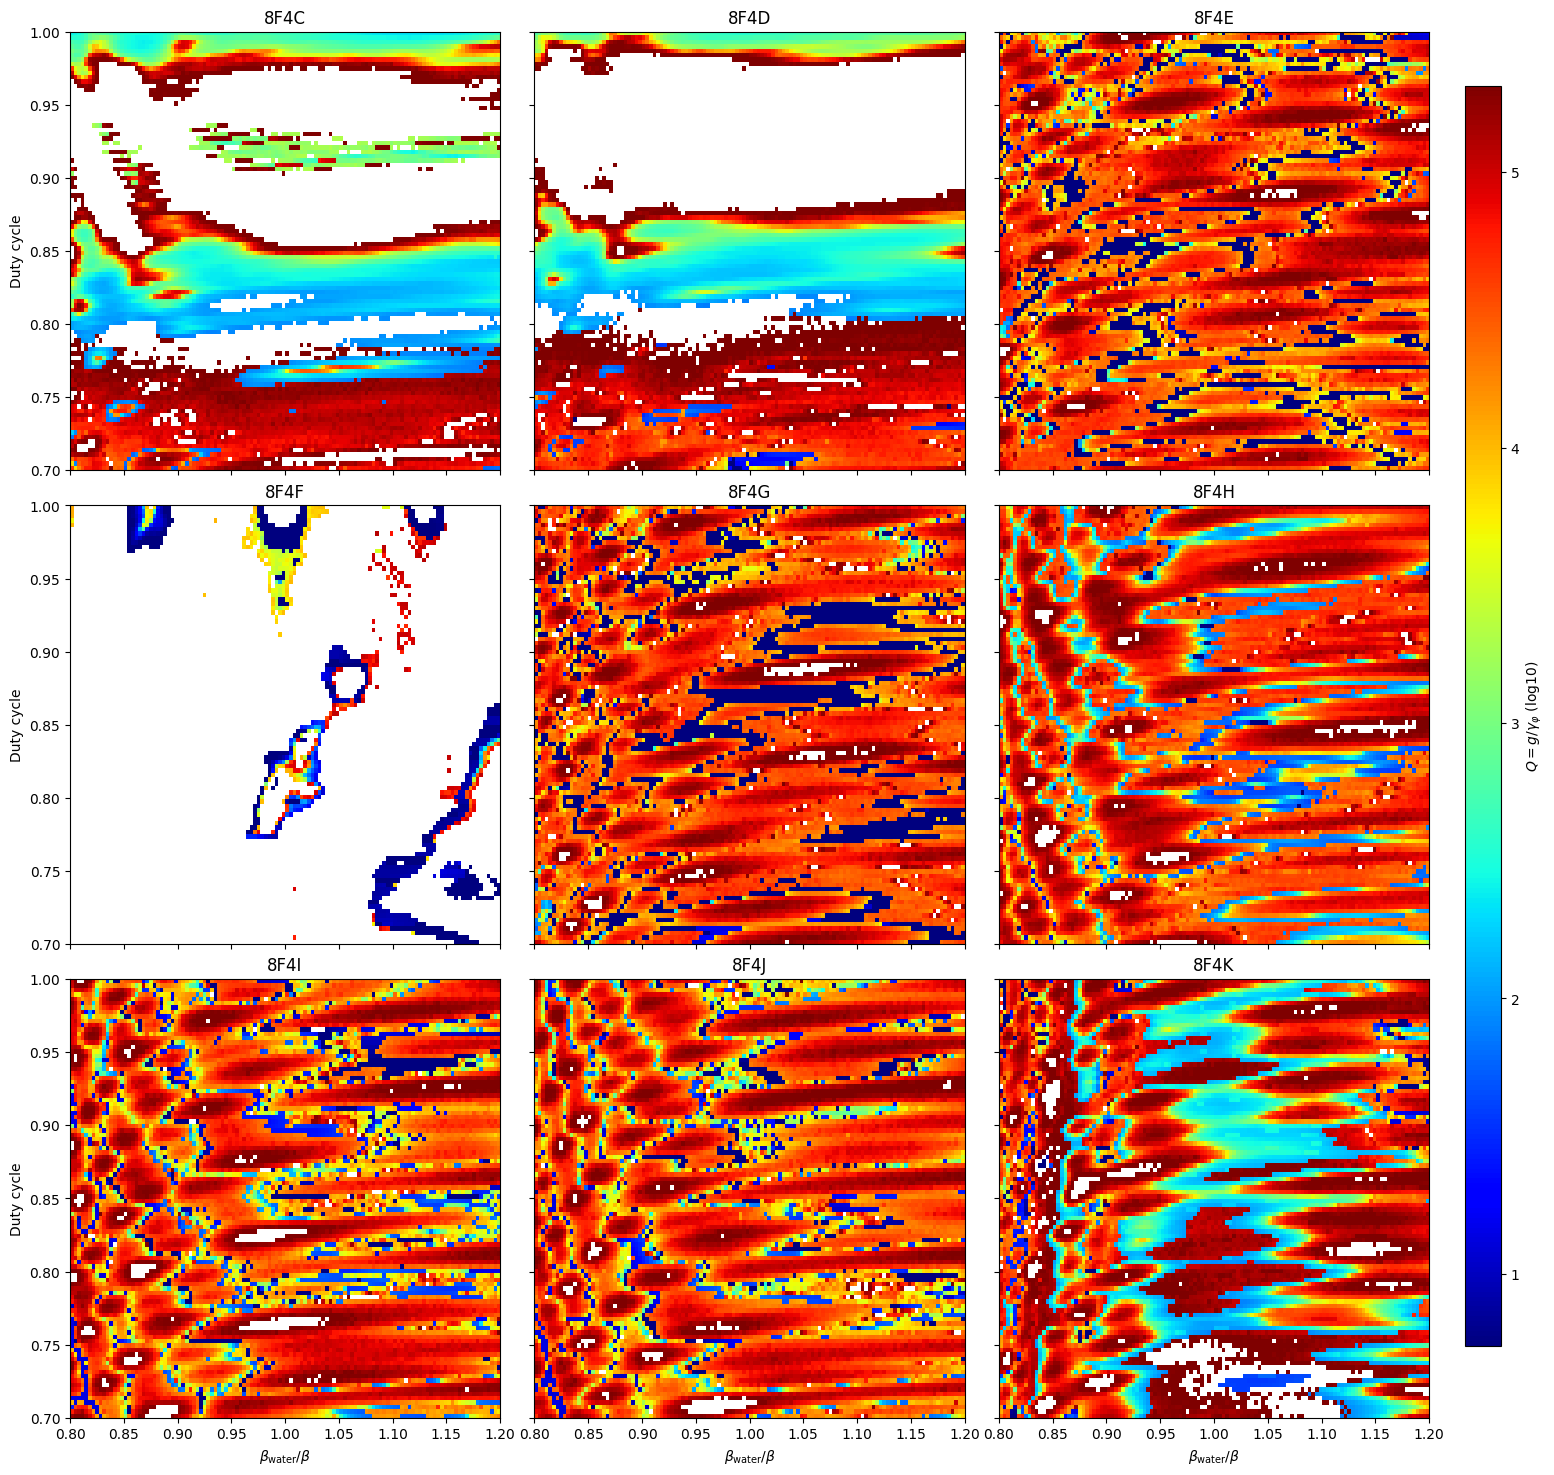


>>> Drawing LOG10(K_masked)


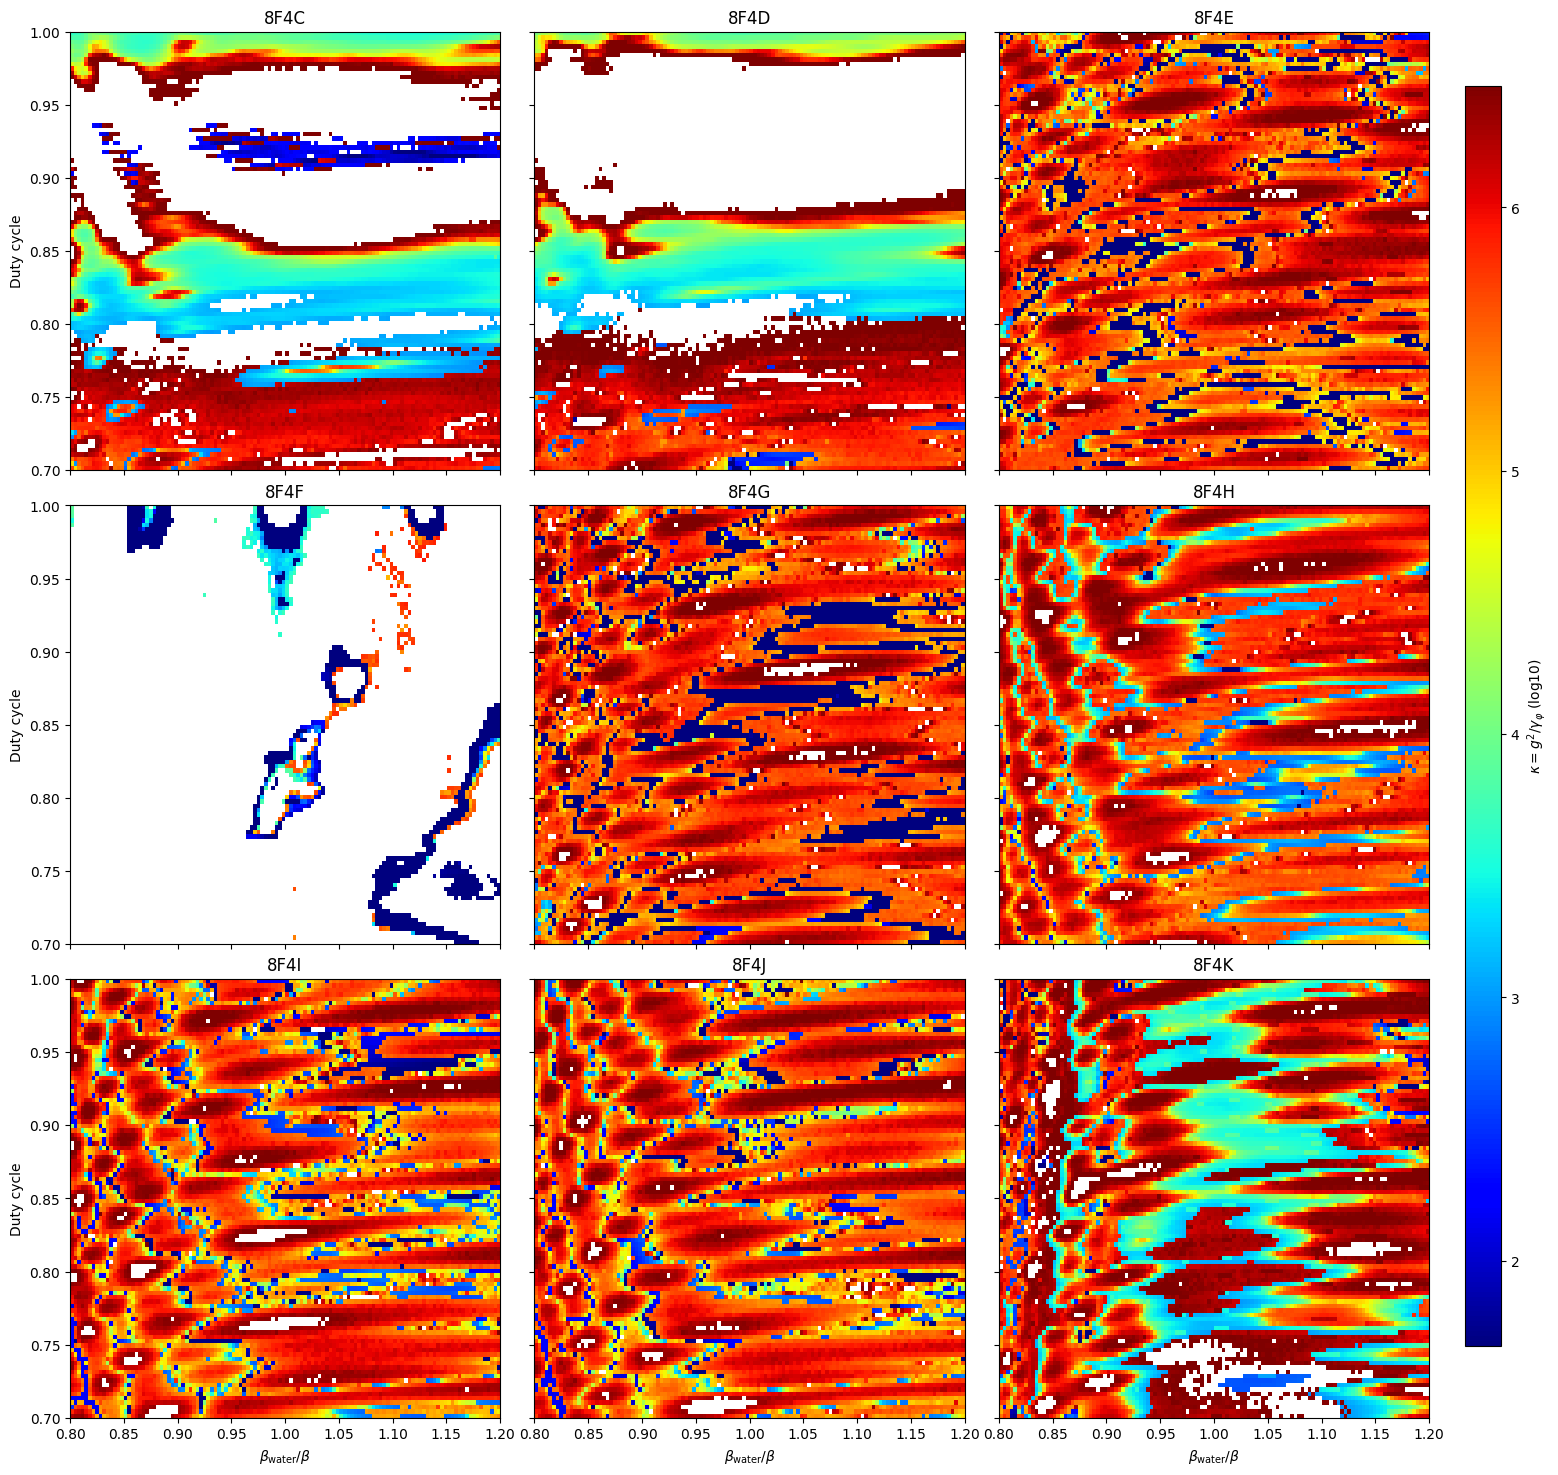


>>> Drawing RATIO κ/Q = g


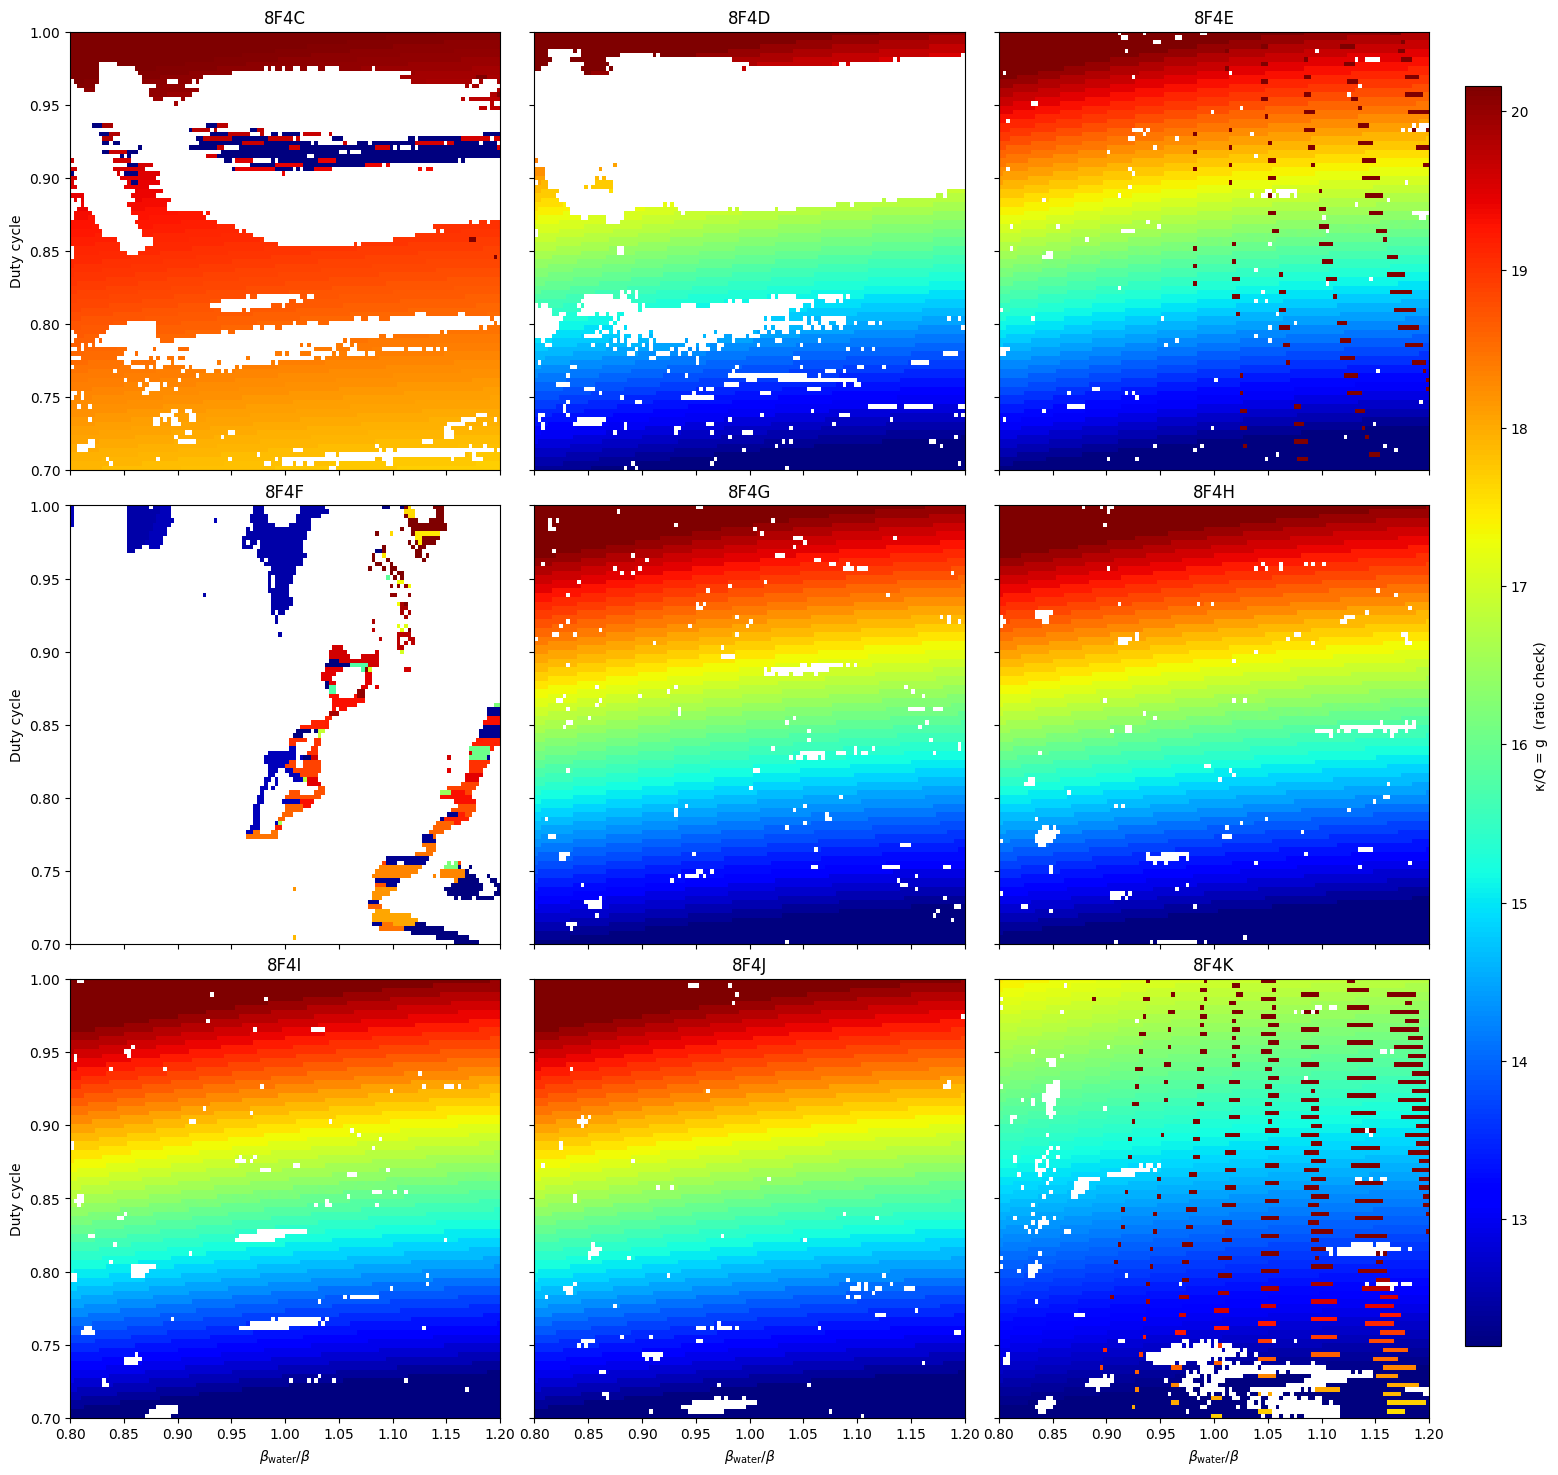


>>> Drawing AUTO-SCALE Q (masked)


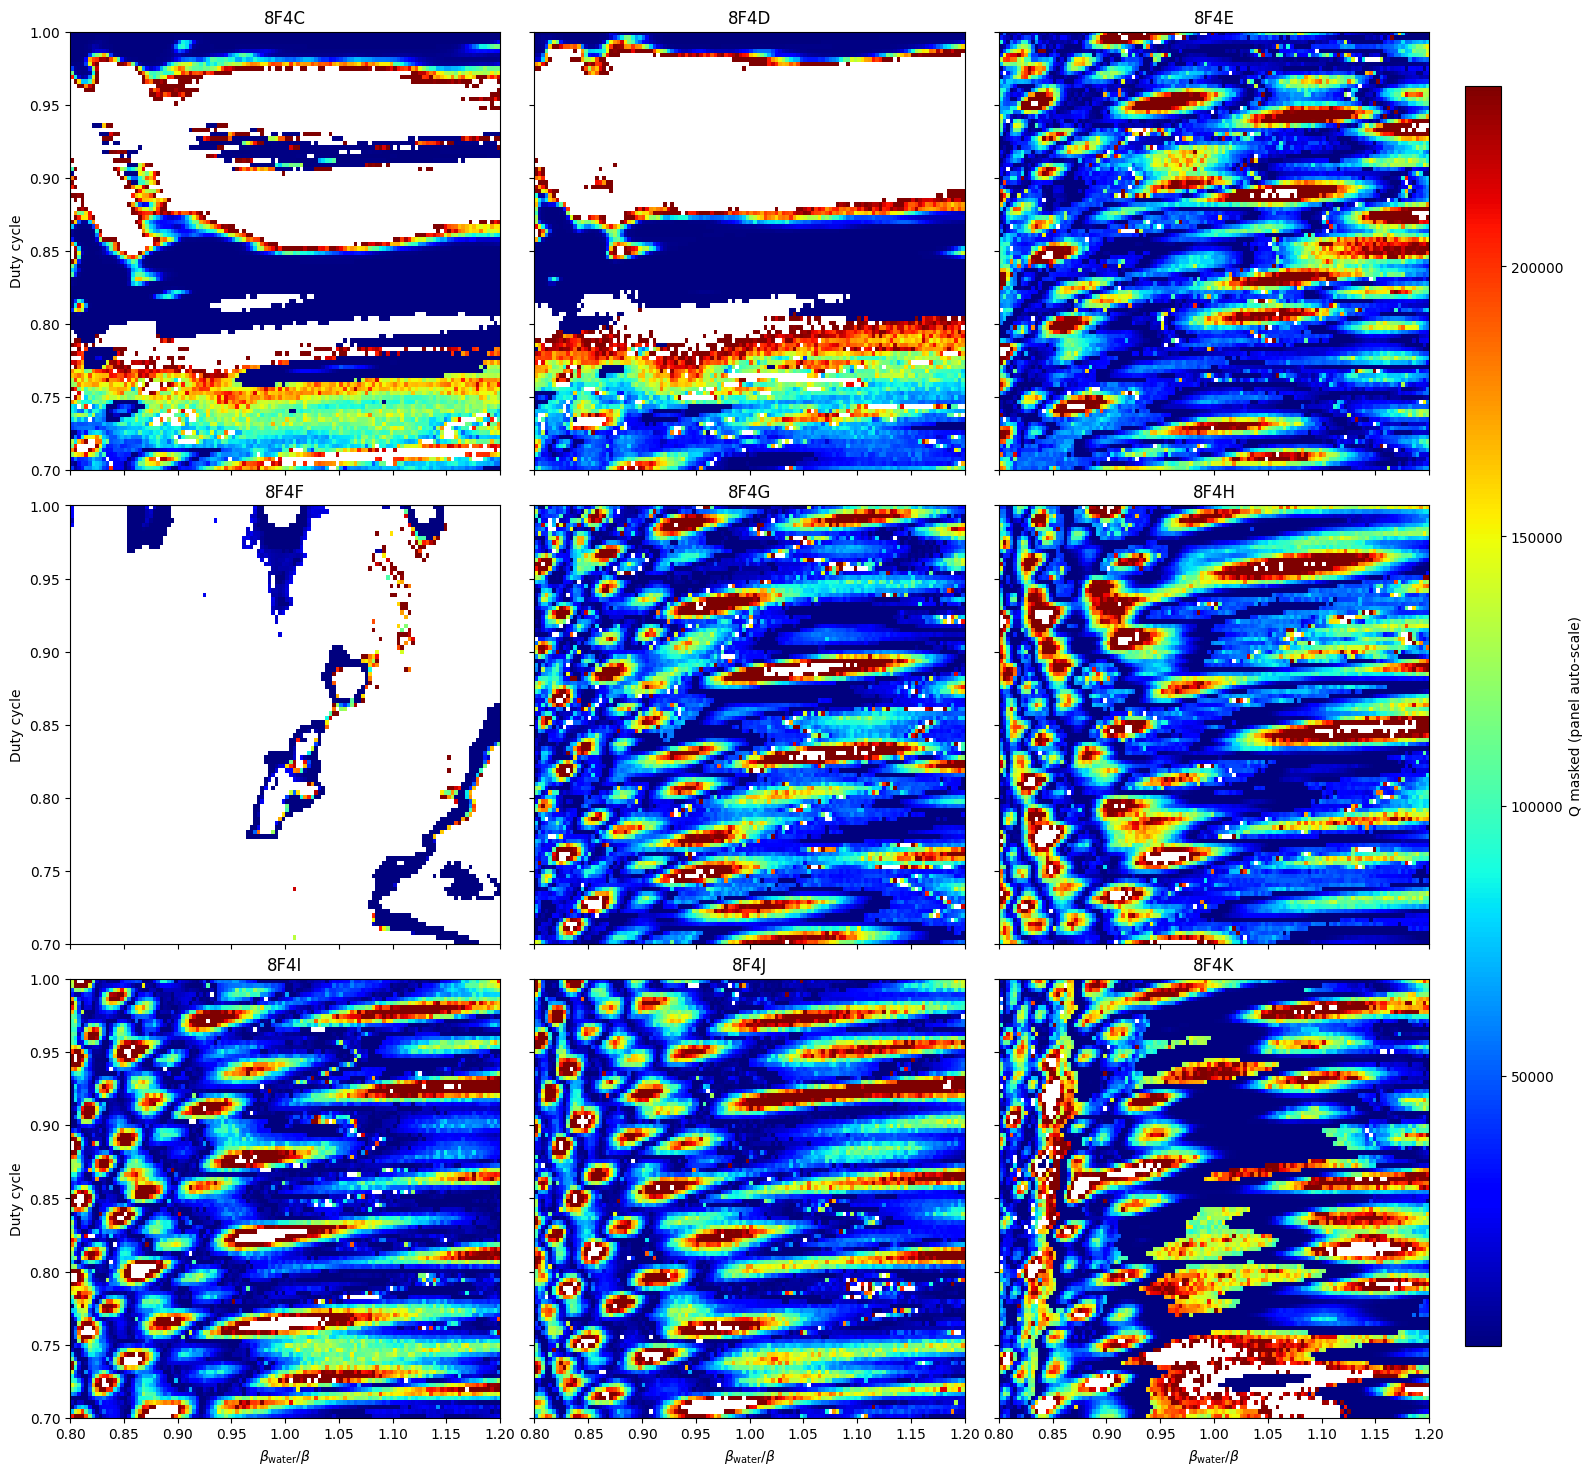


>>> Drawing AUTO-SCALE κ (masked)


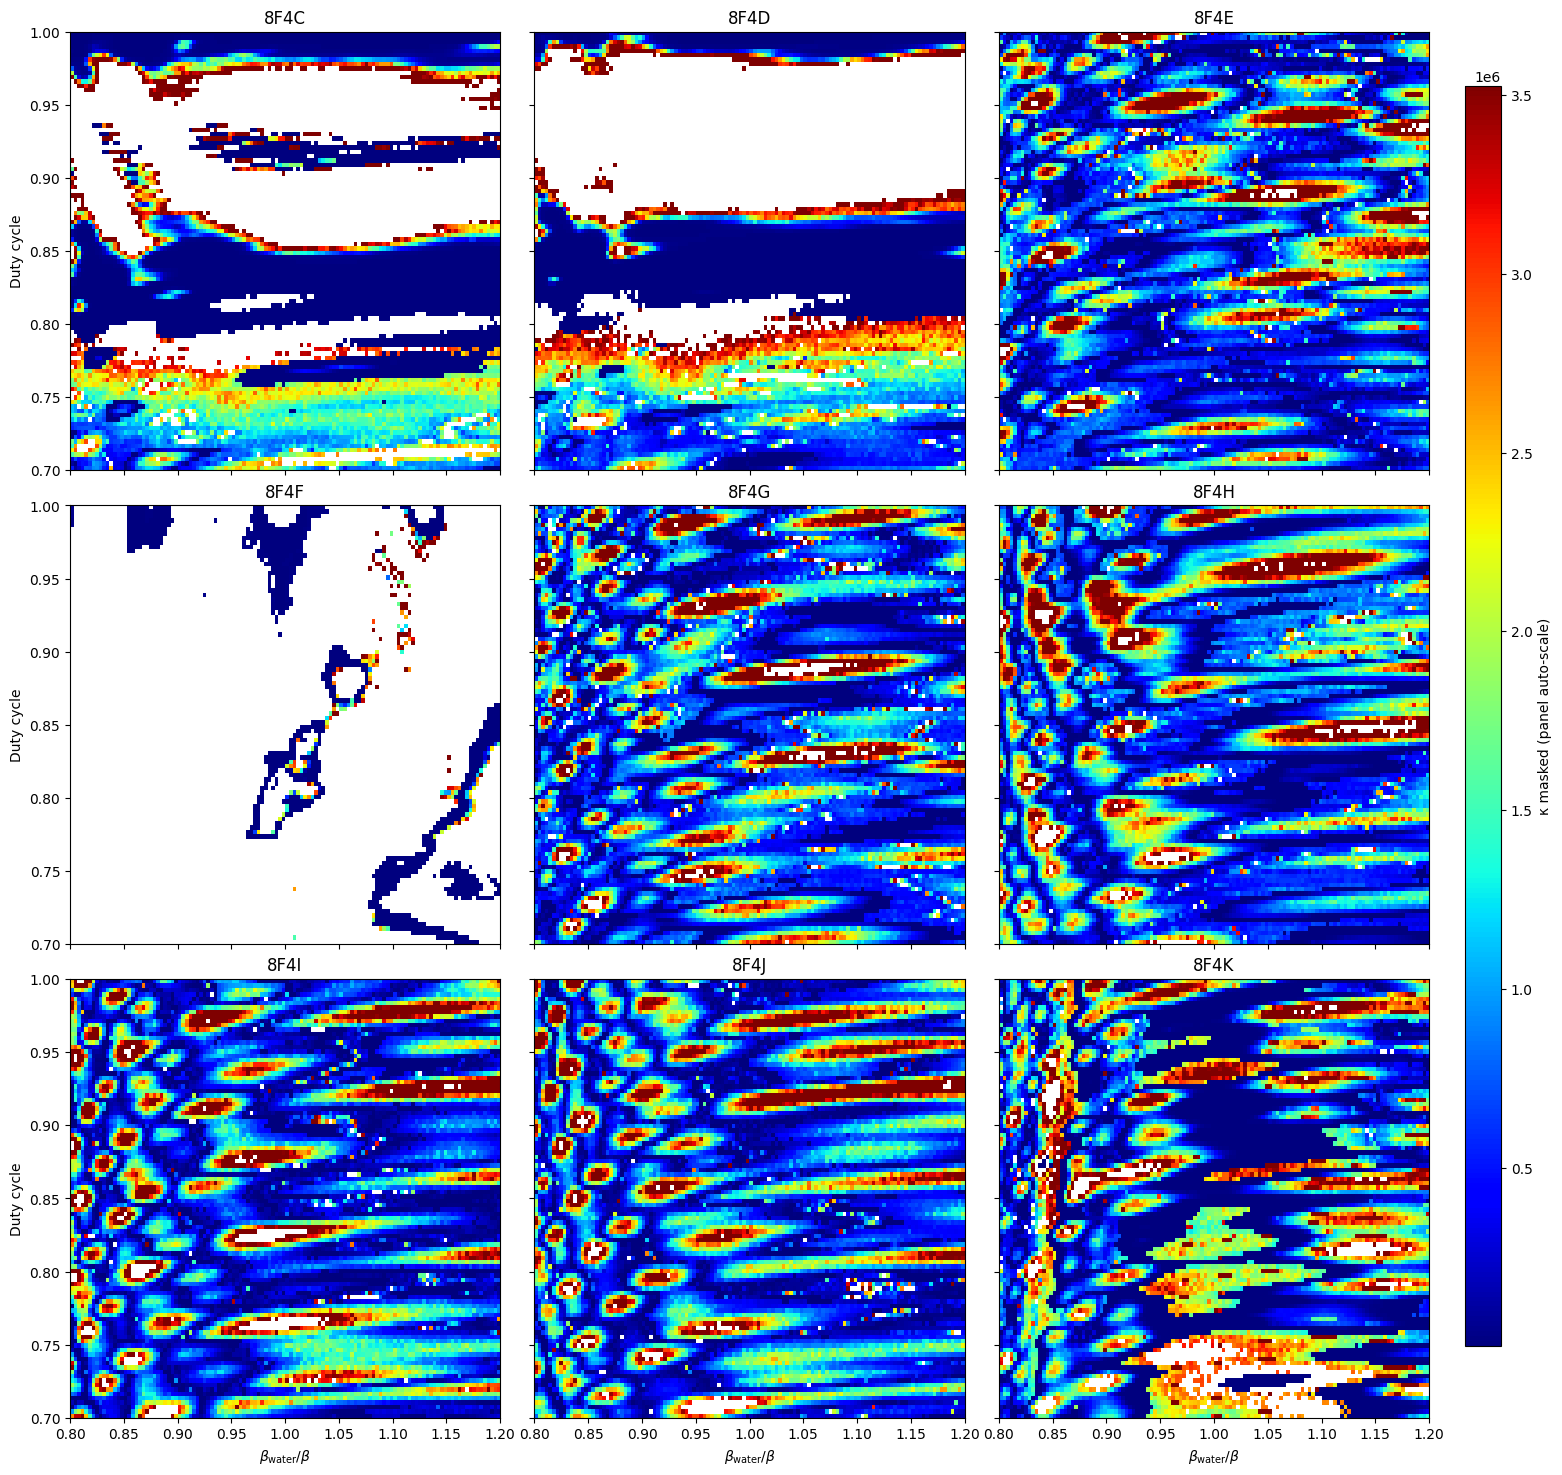

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------
# Load all the DJ_{s}_wow.npz files
# --------------------------------------------
base_dir = Path("/content/dj_maps")
STRUCTURES = [
    "8F4C","8F4D","8F4E",
    "8F4F","8F4G","8F4H",
    "8F4I","8F4J","8F4K",
]

g_all, gamma_all, Q_all, kappa_all = {}, {}, {}, {}
duties, betas = None, None

for s in STRUCTURES:
    dat = np.load(base_dir / f"DJ_{s}_wow.npz")
    if duties is None:
        duties = dat["duties"]
        betas  = dat["betas"]
    g_all[s]     = dat["g_grid"]
    gamma_all[s] = dat["gamma_grid"]
    Q_all[s]     = dat["Q_grid"]
    kappa_all[s] = dat["kappa_grid"]

extent = [betas[0], betas[-1], duties[0], duties[-1]]

# ---------------------------------------------------------
# MASKING — choose gamma threshold based on 20% percentile
# ---------------------------------------------------------
gamma_stack = np.stack([gamma_all[s] for s in STRUCTURES], axis=0)
gamma_valid = gamma_stack[np.isfinite(gamma_stack) & (gamma_stack > 0)]

GAMMA_MIN = float(np.nanpercentile(gamma_valid, 20.0))
print("Gamma threshold chosen =", GAMMA_MIN)

Q_masked, K_masked = {}, {}

for s in STRUCTURES:
    g, gamma, Q, K = g_all[s], gamma_all[s], Q_all[s], kappa_all[s]

    valid = (gamma > GAMMA_MIN) & np.isfinite(Q) & np.isfinite(K)
    Qm = np.full_like(Q, np.nan)
    Km = np.full_like(K, np.nan)
    Qm[valid] = Q[valid]
    Km[valid] = K[valid]
    Q_masked[s] = Qm
    K_masked[s] = Km

# ---------------------------------------------------------
# LOG10 Q and LOG10 K (masked)
# ---------------------------------------------------------
def composite_log(grid_dict, title, fname):
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(18,18), sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    # gather values for scaling
    vals = np.hstack([grid_dict[s][np.isfinite(grid_dict[s])] for s in STRUCTURES])
    vmin, vmax = np.nanpercentile(vals, 5), np.nanpercentile(vals, 95)

    for k,s in enumerate(STRUCTURES):
        r, c = k//cols, k%cols
        ax = axes[r,c]
        grid = grid_dict[s]
        im = ax.imshow(np.log10(grid), origin="lower", extent=extent,
                       interpolation="nearest", aspect="auto",
                       vmin=np.log10(vmin), vmax=np.log10(vmax), cmap="jet")
        ax.set_title(s)
        if r==2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c==0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title + " (log10)")

    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    plt.show()

print("\n>>> Drawing LOG10(Q_masked)")
composite_log(Q_masked, r"$Q = g/\gamma_{\varphi}$", "Composite_LOG_Q_masked")

print("\n>>> Drawing LOG10(K_masked)")
composite_log(K_masked, r"$\kappa = g^2/\gamma_{\varphi}$", "Composite_LOG_K_masked")

# ---------------------------------------------------------
# RATIO: kappa/Q = g  (sanity check)
# ---------------------------------------------------------
def composite_ratio(title, fname):
    fig, axes = plt.subplots(3, 3, figsize=(18,18), sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    for k,s in enumerate(STRUCTURES):
        r, c = k//3, k%3
        ax = axes[r,c]
        ratio = np.full_like(g_all[s], np.nan)
        mask = np.isfinite(Q_masked[s]) & np.isfinite(K_masked[s])
        ratio[mask] = K_masked[s][mask] / Q_masked[s][mask]  # = g

        gvals = ratio[np.isfinite(ratio)]
        vmin, vmax = np.nanpercentile(gvals, 5), np.nanpercentile(gvals, 95)

        im = ax.imshow(ratio, origin="lower", extent=extent,
                       interpolation="nearest", aspect="auto",
                       vmin=vmin, vmax=vmax, cmap="jet")
        ax.set_title(s)
        if r==2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c==0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title)
    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    plt.show()

print("\n>>> Drawing RATIO κ/Q = g")
composite_ratio("κ/Q = g  (ratio check)", "Composite_ratio_K_over_Q")

# ---------------------------------------------------------
# Per-panel autoscale for Q and κ — reveals structural differences
# ---------------------------------------------------------
def composite_autoscale(grid_dict, title, fname):
    fig, axes = plt.subplots(3,3, figsize=(18,18), sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    for k,s in enumerate(STRUCTURES):
        r,c = k//3, k%3
        ax = axes[r,c]
        grid = grid_dict[s]
        vals = grid[np.isfinite(grid)]
        if vals.size==0:
            im=ax.imshow(grid, origin="lower", extent=extent); continue
        vmin, vmax = np.nanpercentile(vals, 5), np.nanpercentile(vals, 95)

        im = ax.imshow(grid, origin="lower", extent=extent,
                       interpolation="nearest", aspect="auto",
                       vmin=vmin, vmax=vmax, cmap="jet")
        ax.set_title(s)
        if r==2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c==0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title)
    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    plt.show()

print("\n>>> Drawing AUTO-SCALE Q (masked)")
composite_autoscale(Q_masked, "Q masked (panel auto-scale)", "Composite_Q_masked_autoscale")

print("\n>>> Drawing AUTO-SCALE κ (masked)")
composite_autoscale(K_masked, "κ masked (panel auto-scale)", "Composite_K_masked_autoscale")

In [ ]:
import matplotlib.pyplot as plt
import re
from pathlib import Path

save_dir = Path("/content/dj_maps")
save_dir.mkdir(exist_ok=True)

def safe_filename(name):
    """Convert title/label text into a safe filename."""
    name = name.strip()
    # remove LaTeX $, {} etc
    name = re.sub(r'[^a-zA-Z0-9_\-]+', '_', name)
    name = re.sub(r'__+', '_', name)
    return name or "figure"

# Loop over all active figures
for i in plt.get_fignums():
    fig = plt.figure(i)

    # Try to get title text
    if fig._suptitle is not None:
        title = fig._suptitle.get_text()
    else:
        title = f"figure_{i}"

    fname = safe_filename(title)

    png_path = save_dir / f"{fname}.png"
    pdf_path = save_dir / f"{fname}.pdf"

    fig.savefig(png_path, dpi=600)
    fig.savefig(pdf_path)

    print(f"Saved Figure {i} as:\n   {png_path}\n   {pdf_path}")

In [ ]:
import shutil
from pathlib import Path

SOURCE_DIR = Path("/content/dj_maps")
ZIP_CT     = Path("/content/dj_maps.zip")
ZIP_DR     = Path("/content/drive/MyDrive/dj_maps.zip")

# Create ZIP in /content
shutil.make_archive(
    base_name=str(ZIP_CT).replace(".zip",""),
    format="zip",
    root_dir=str(SOURCE_DIR)
)

# Copy ZIP to Google Drive
shutil.copy2(ZIP_CT, ZIP_DR)

print("Zipped folder successfully:")
print("  Local : ", ZIP_CT)
print("  Drive : ", ZIP_DR)

Zipped folder successfully:
  Local :  /content/dj_maps.zip
  Drive :  /content/drive/MyDrive/dj_maps.zip


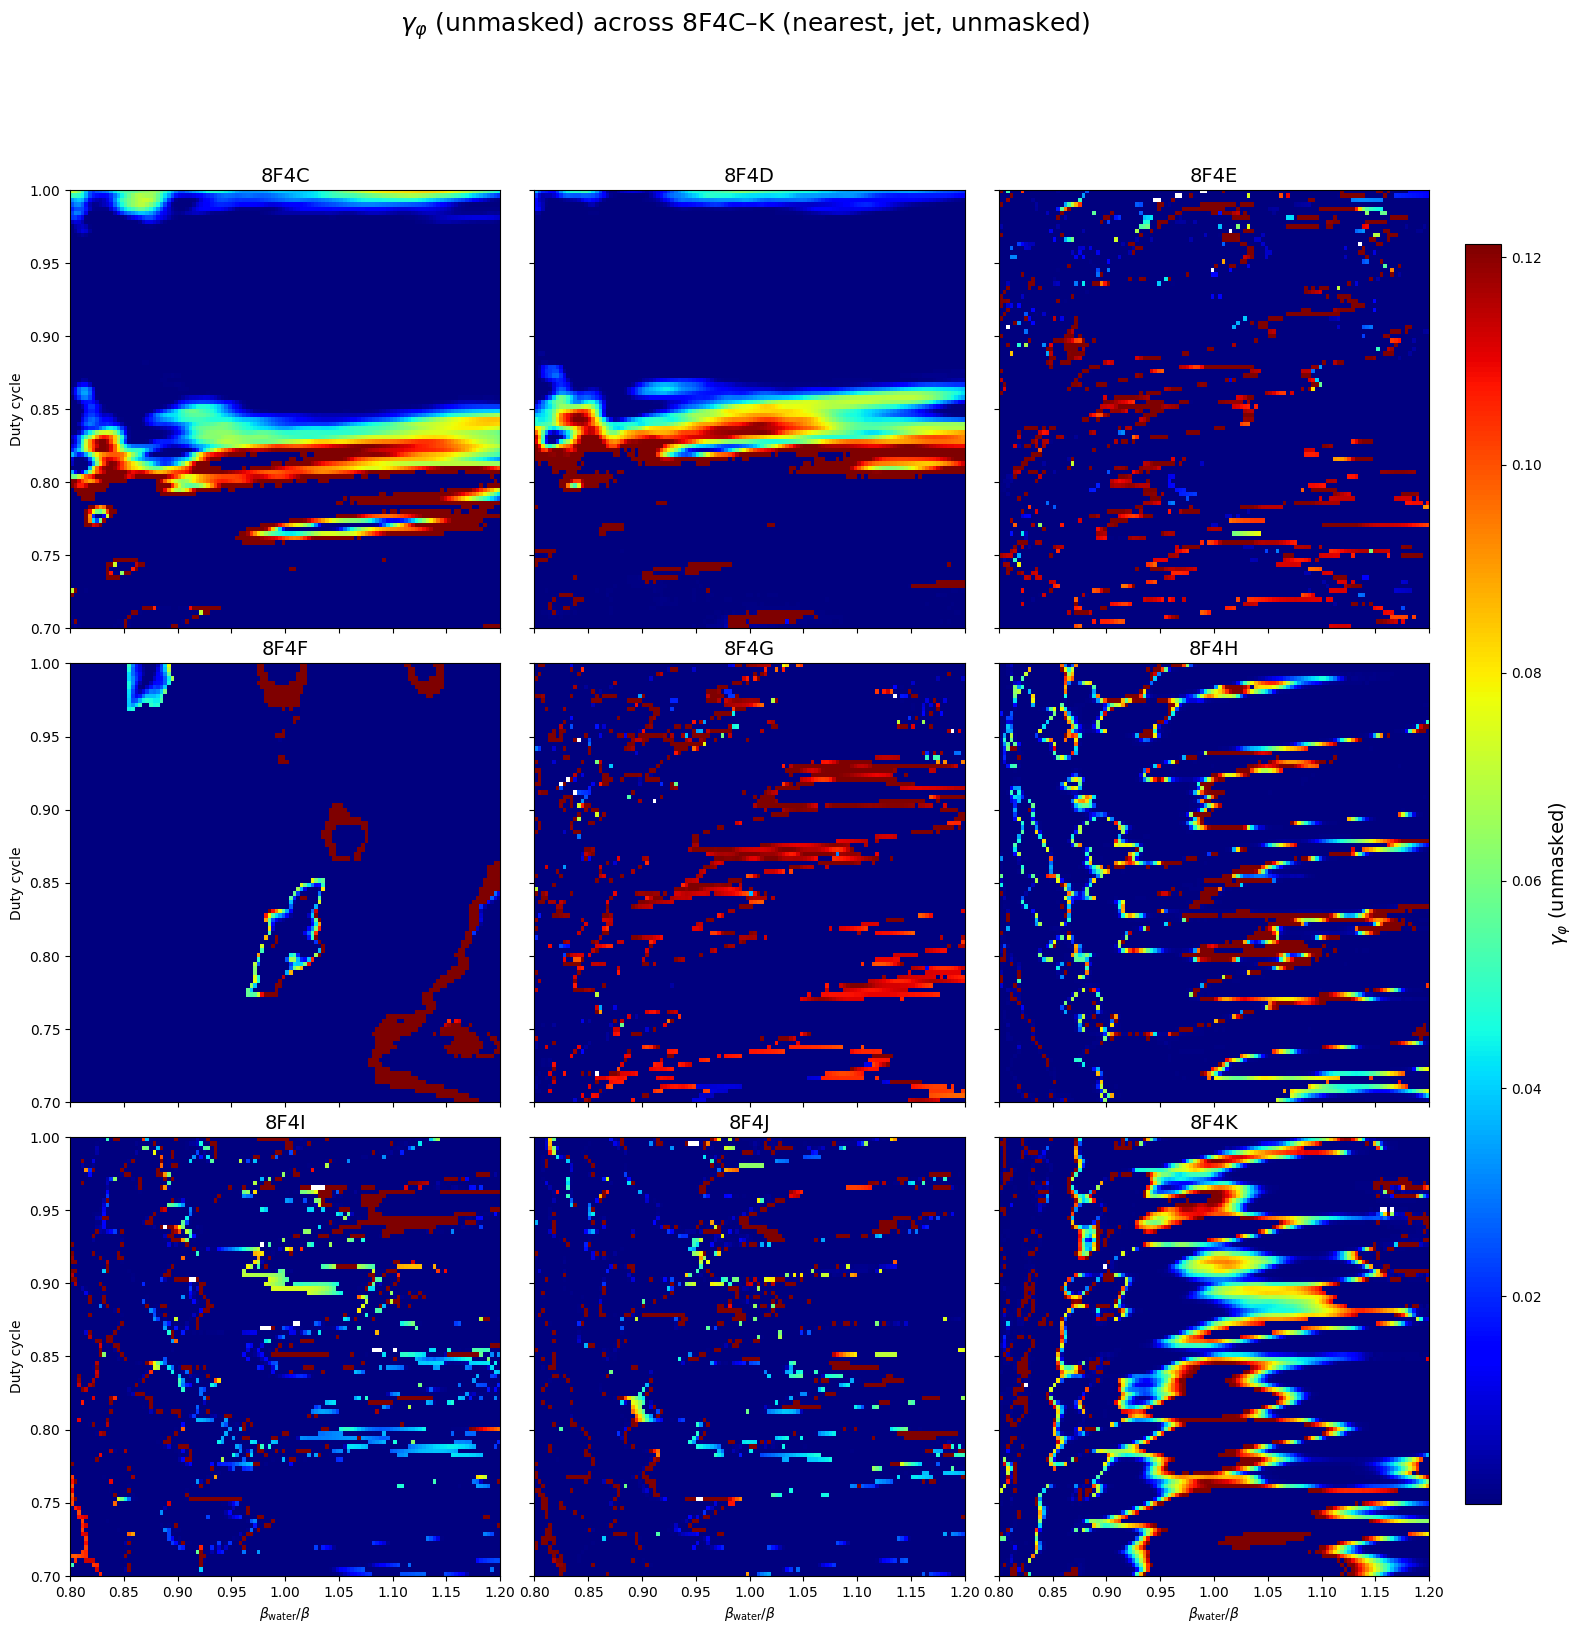

Saved:
  /content/dj_maps/Composite_gamma_unmasked_autoscale.png
  /content/dj_maps/Composite_gamma_unmasked_autoscale.pdf


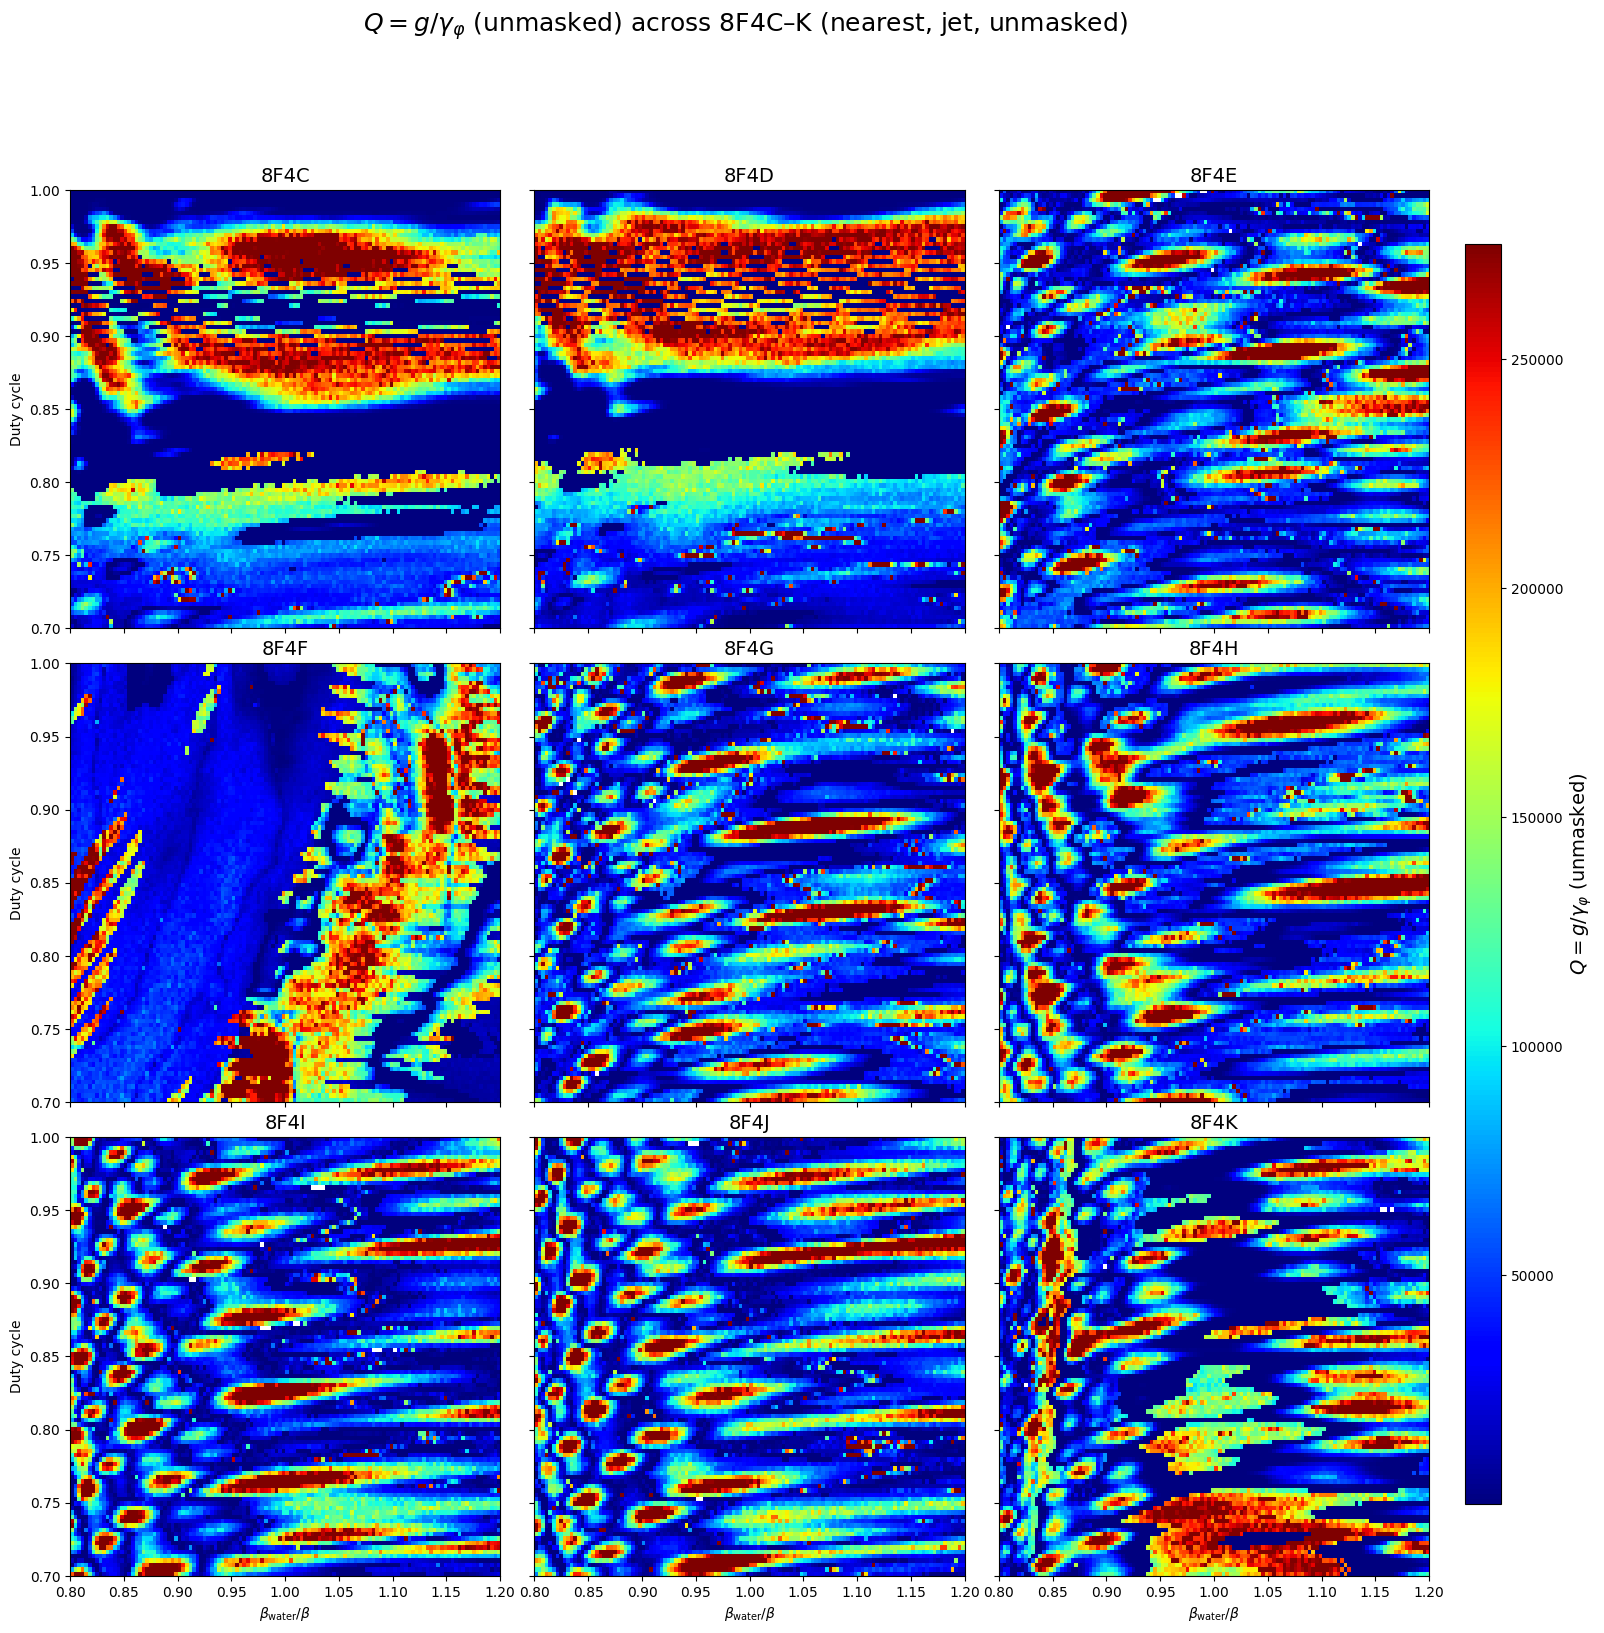

Saved:
  /content/dj_maps/Composite_Q_unmasked_autoscale.png
  /content/dj_maps/Composite_Q_unmasked_autoscale.pdf


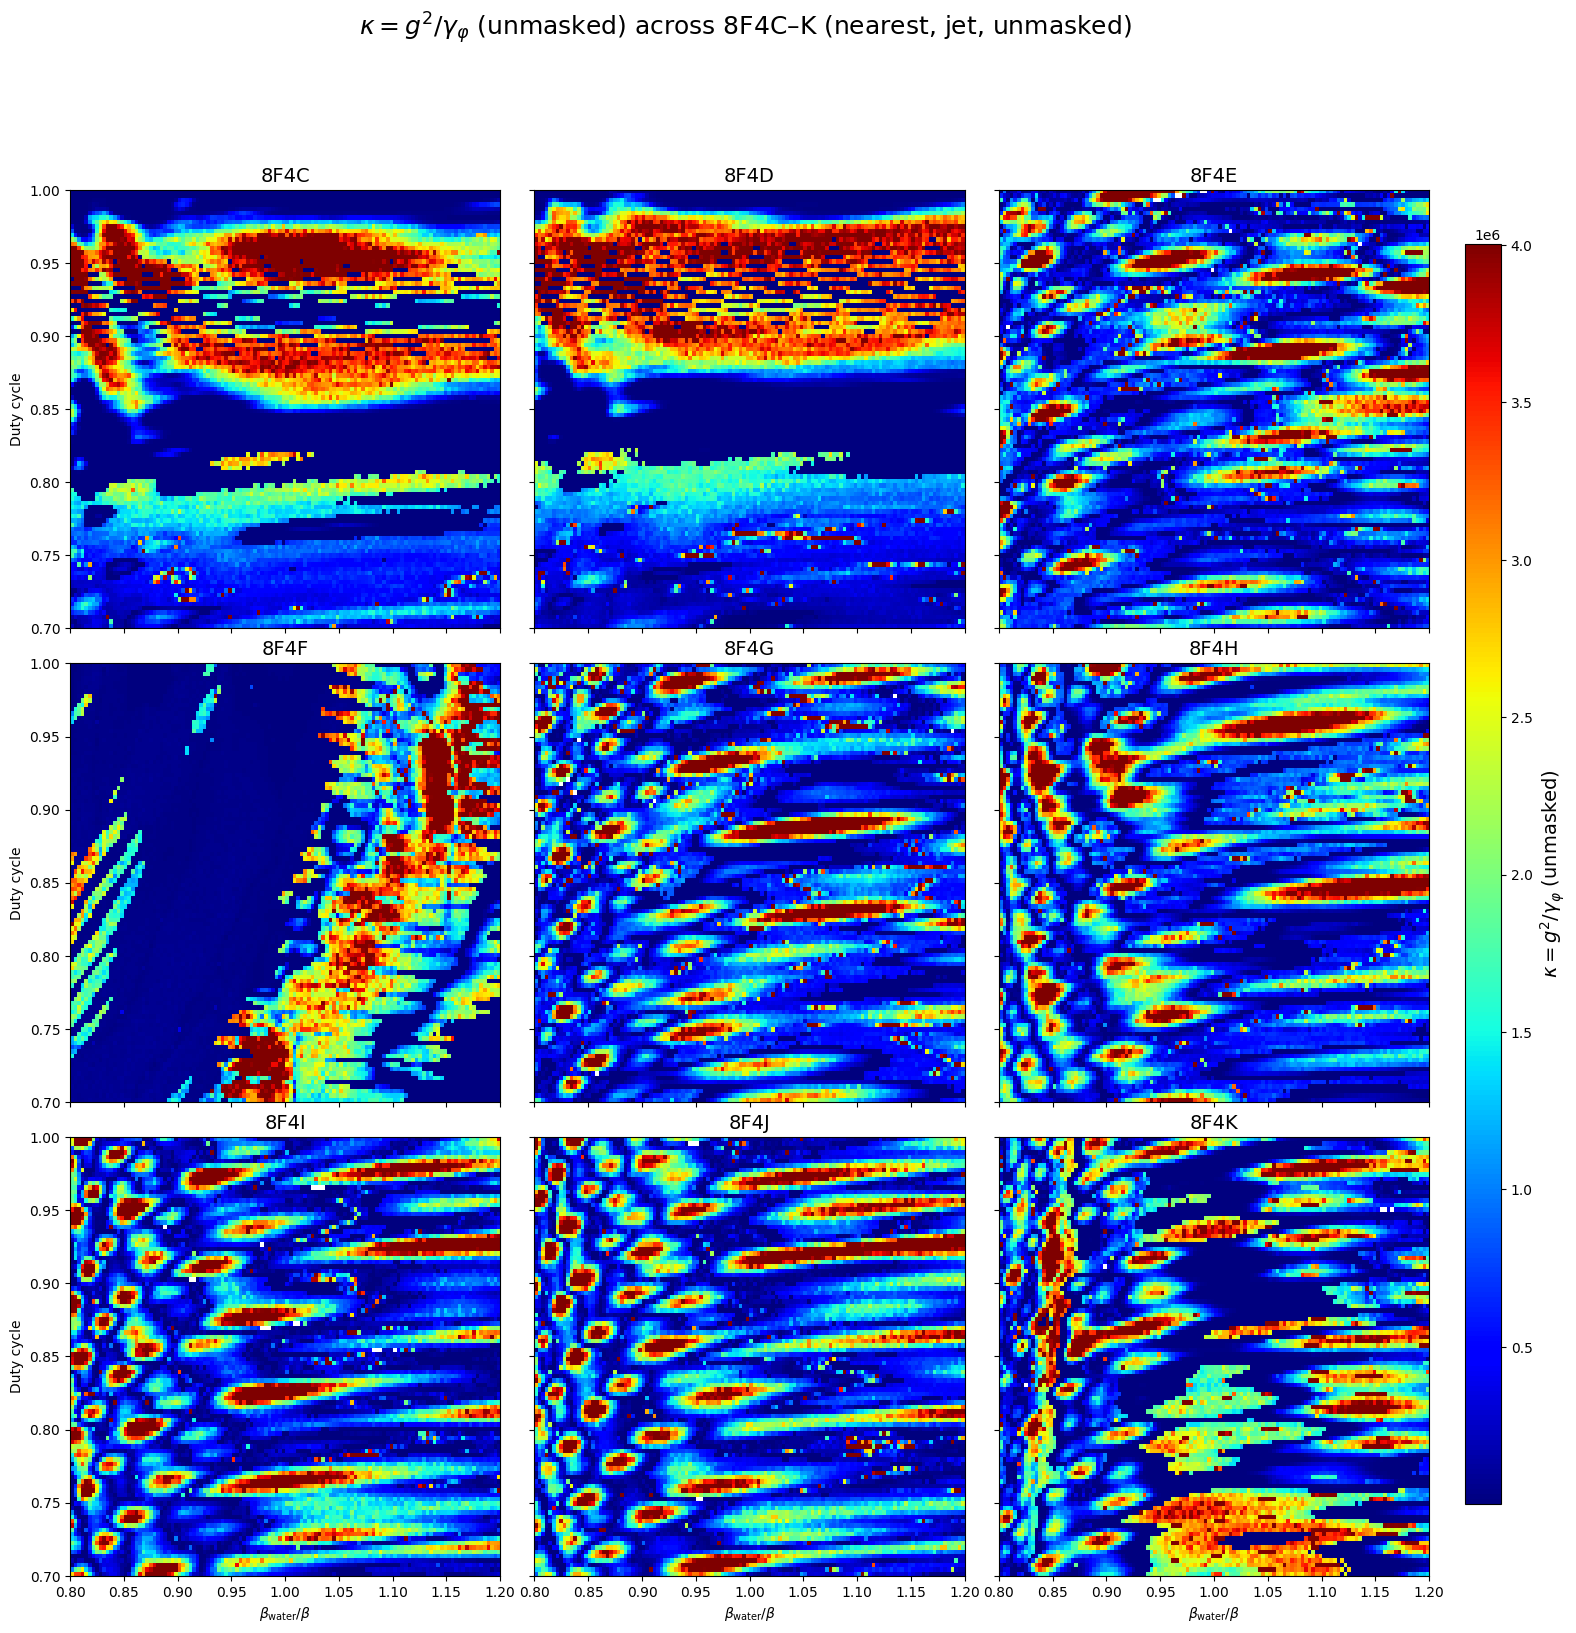

Saved:
  /content/dj_maps/Composite_kappa_unmasked_autoscale.png
  /content/dj_maps/Composite_kappa_unmasked_autoscale.pdf


In [ ]:
# ============================================================
#  Unmasked γ, Q, κ composites (panel auto-scale, saved)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_dir   = Path("/content/dj_maps")
STRUCTURES = [
    "8F4C","8F4D","8F4E",
    "8F4F","8F4G","8F4H",
    "8F4I","8F4J","8F4K",
]

# ---- load everything fresh ----
g_all, gamma_all, Q_all, K_all = {}, {}, {}, {}
duties, betas = None, None

for s in STRUCTURES:
    dat = np.load(base_dir / f"DJ_{s}_wow.npz")
    if duties is None:
        duties = dat["duties"]
        betas  = dat["betas"]
    g_all[s]     = dat["g_grid"]
    gamma_all[s] = dat["gamma_grid"]
    Q_all[s]     = dat["Q_grid"]
    K_all[s]     = dat["kappa_grid"]

extent = [betas[0], betas[-1], duties[0], duties[-1]]


# -----------------------------------------------------------
# Generic auto-scaled composite plot for ANY quantity
# -----------------------------------------------------------
def composite_autoscale(grid_dict, title, fname_stub):

    rows, cols = 3, 3

    fig, axes = plt.subplots(rows, cols, figsize=(18, 18),
                             sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.08)

    for k, s in enumerate(STRUCTURES):
        r, c = k // cols, k % cols
        ax = axes[r, c]
        grid = grid_dict[s]

        # get per-panel colour limits
        vals = grid[np.isfinite(grid)]
        if vals.size > 0:
            vmin = float(np.nanpercentile(vals, 5))
            vmax = float(np.nanpercentile(vals, 95))
        else:
            vmin, vmax = 0.0, 1.0

        im = ax.imshow(
            grid,
            origin="lower",
            extent=extent,
            interpolation="nearest",
            aspect="auto",
            vmin=vmin, vmax=vmax,
            cmap="jet"
        )

        ax.set_title(s, fontsize=14)
        if r == rows - 1:
            ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c == 0:
            ax.set_ylabel("Duty cycle")

    # shared colourbar
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title, fontsize=14)

    fig.suptitle(f"{title} across 8F4C–K (nearest, jet, unmasked)", fontsize=18)

    # save
    png = base_dir / f"{fname_stub}.png"
    pdf = base_dir / f"{fname_stub}.pdf"
    fig.savefig(png, dpi=600)
    fig.savefig(pdf)

    plt.show()
    print("Saved:")
    print(" ", png)
    print(" ", pdf)


# -----------------------------------------------------------
#  MAKE THE THREE UNMASKED COMPOSITES
# -----------------------------------------------------------

# 1) gamma
composite_autoscale(
    gamma_all,
    r"$\gamma_{\varphi}$ (unmasked)",
    "Composite_gamma_unmasked_autoscale"
)

# 2) Q = g / gamma
composite_autoscale(
    Q_all,
    r"$Q = g/\gamma_{\varphi}$ (unmasked)",
    "Composite_Q_unmasked_autoscale"
)

# 3) kappa = g² / gamma
composite_autoscale(
    K_all,
    r"$\kappa = g^2/\gamma_{\varphi}$ (unmasked)",
    "Composite_kappa_unmasked_autoscale"
)

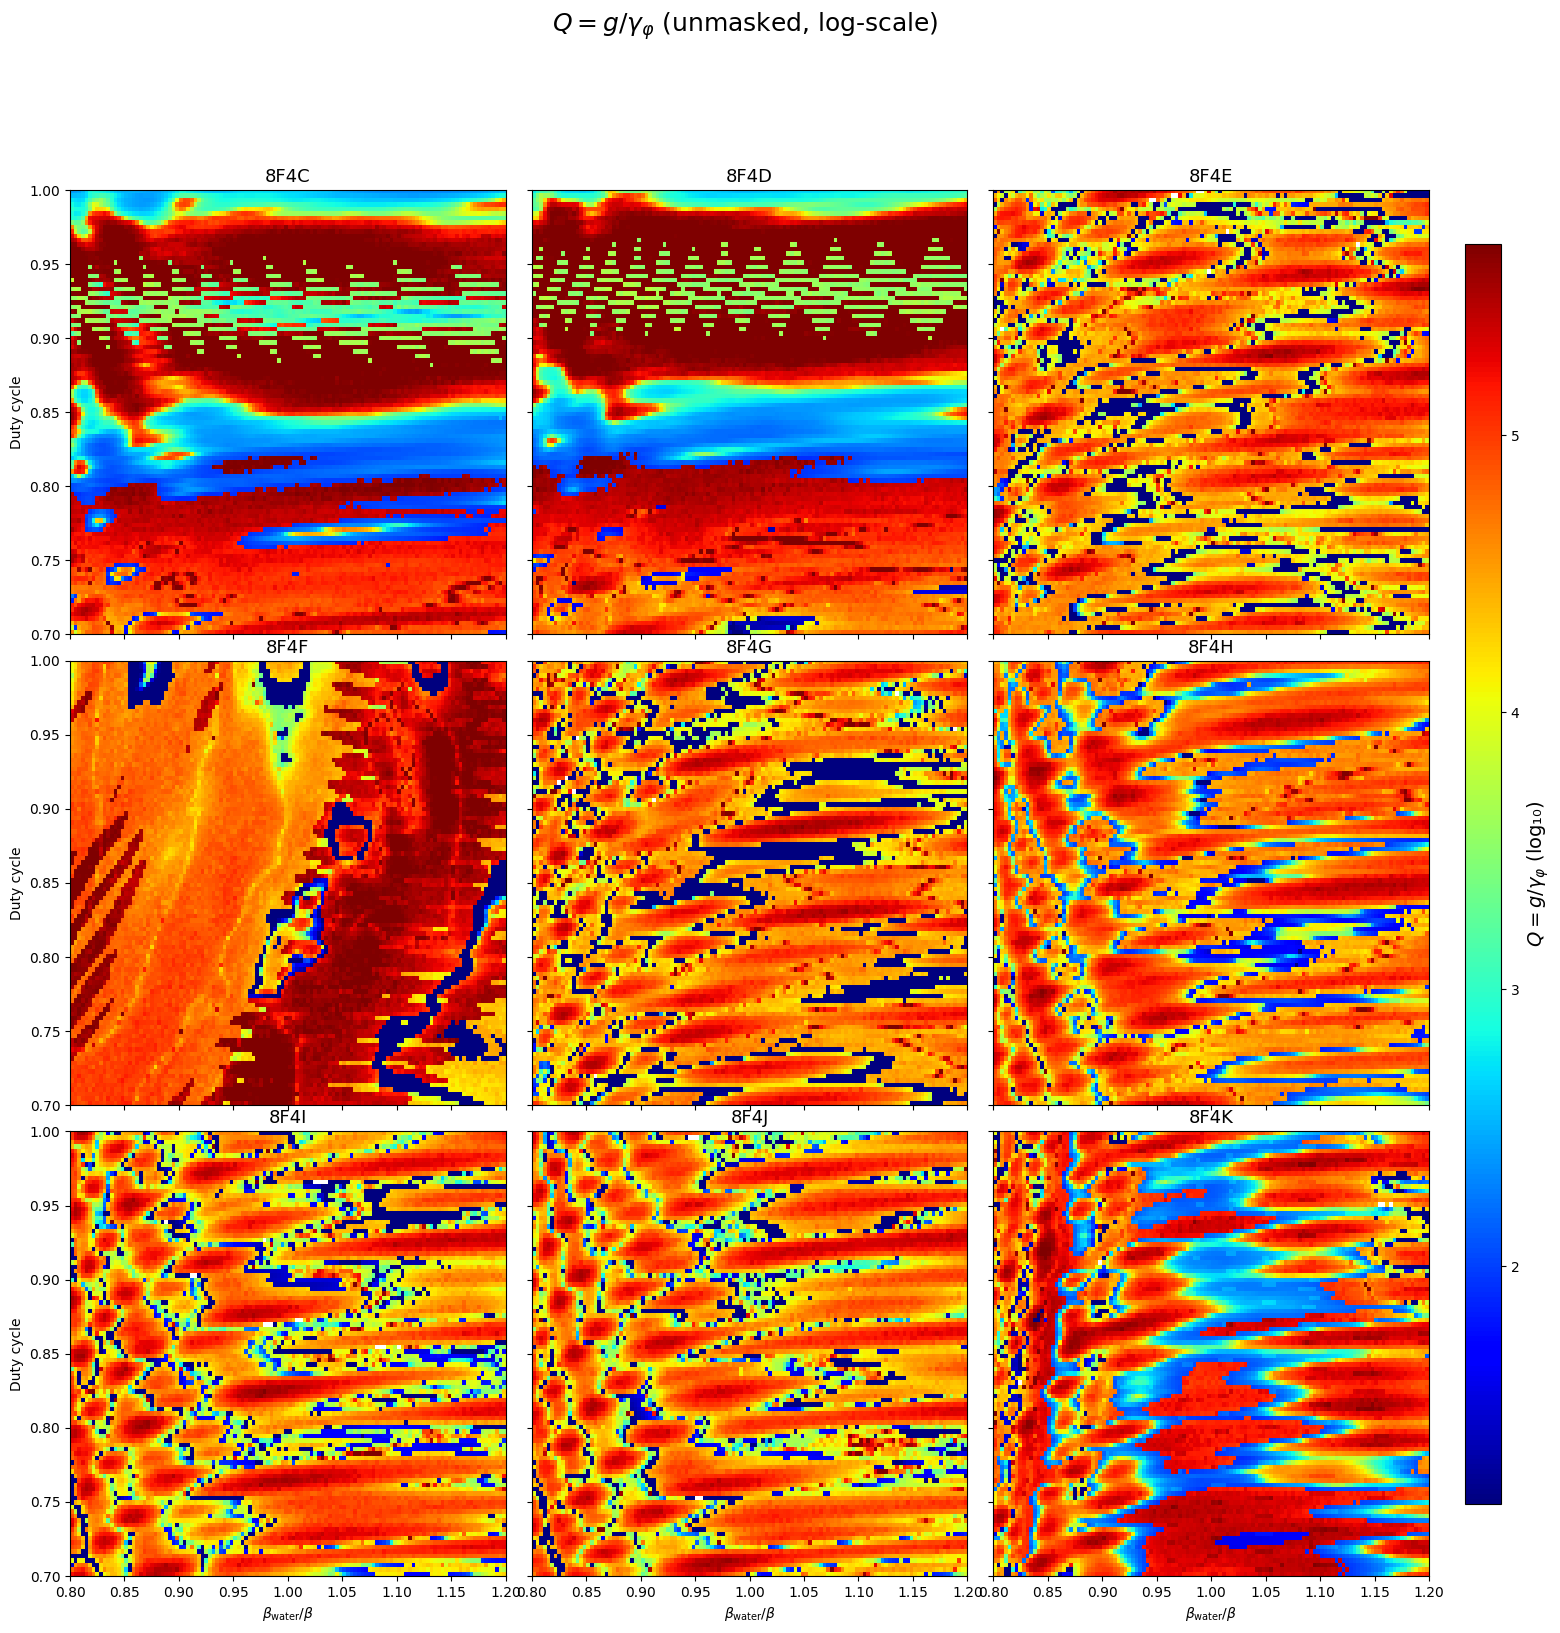

Saved: /content/dj_maps/Composite_LOG10_Q_unmasked.png


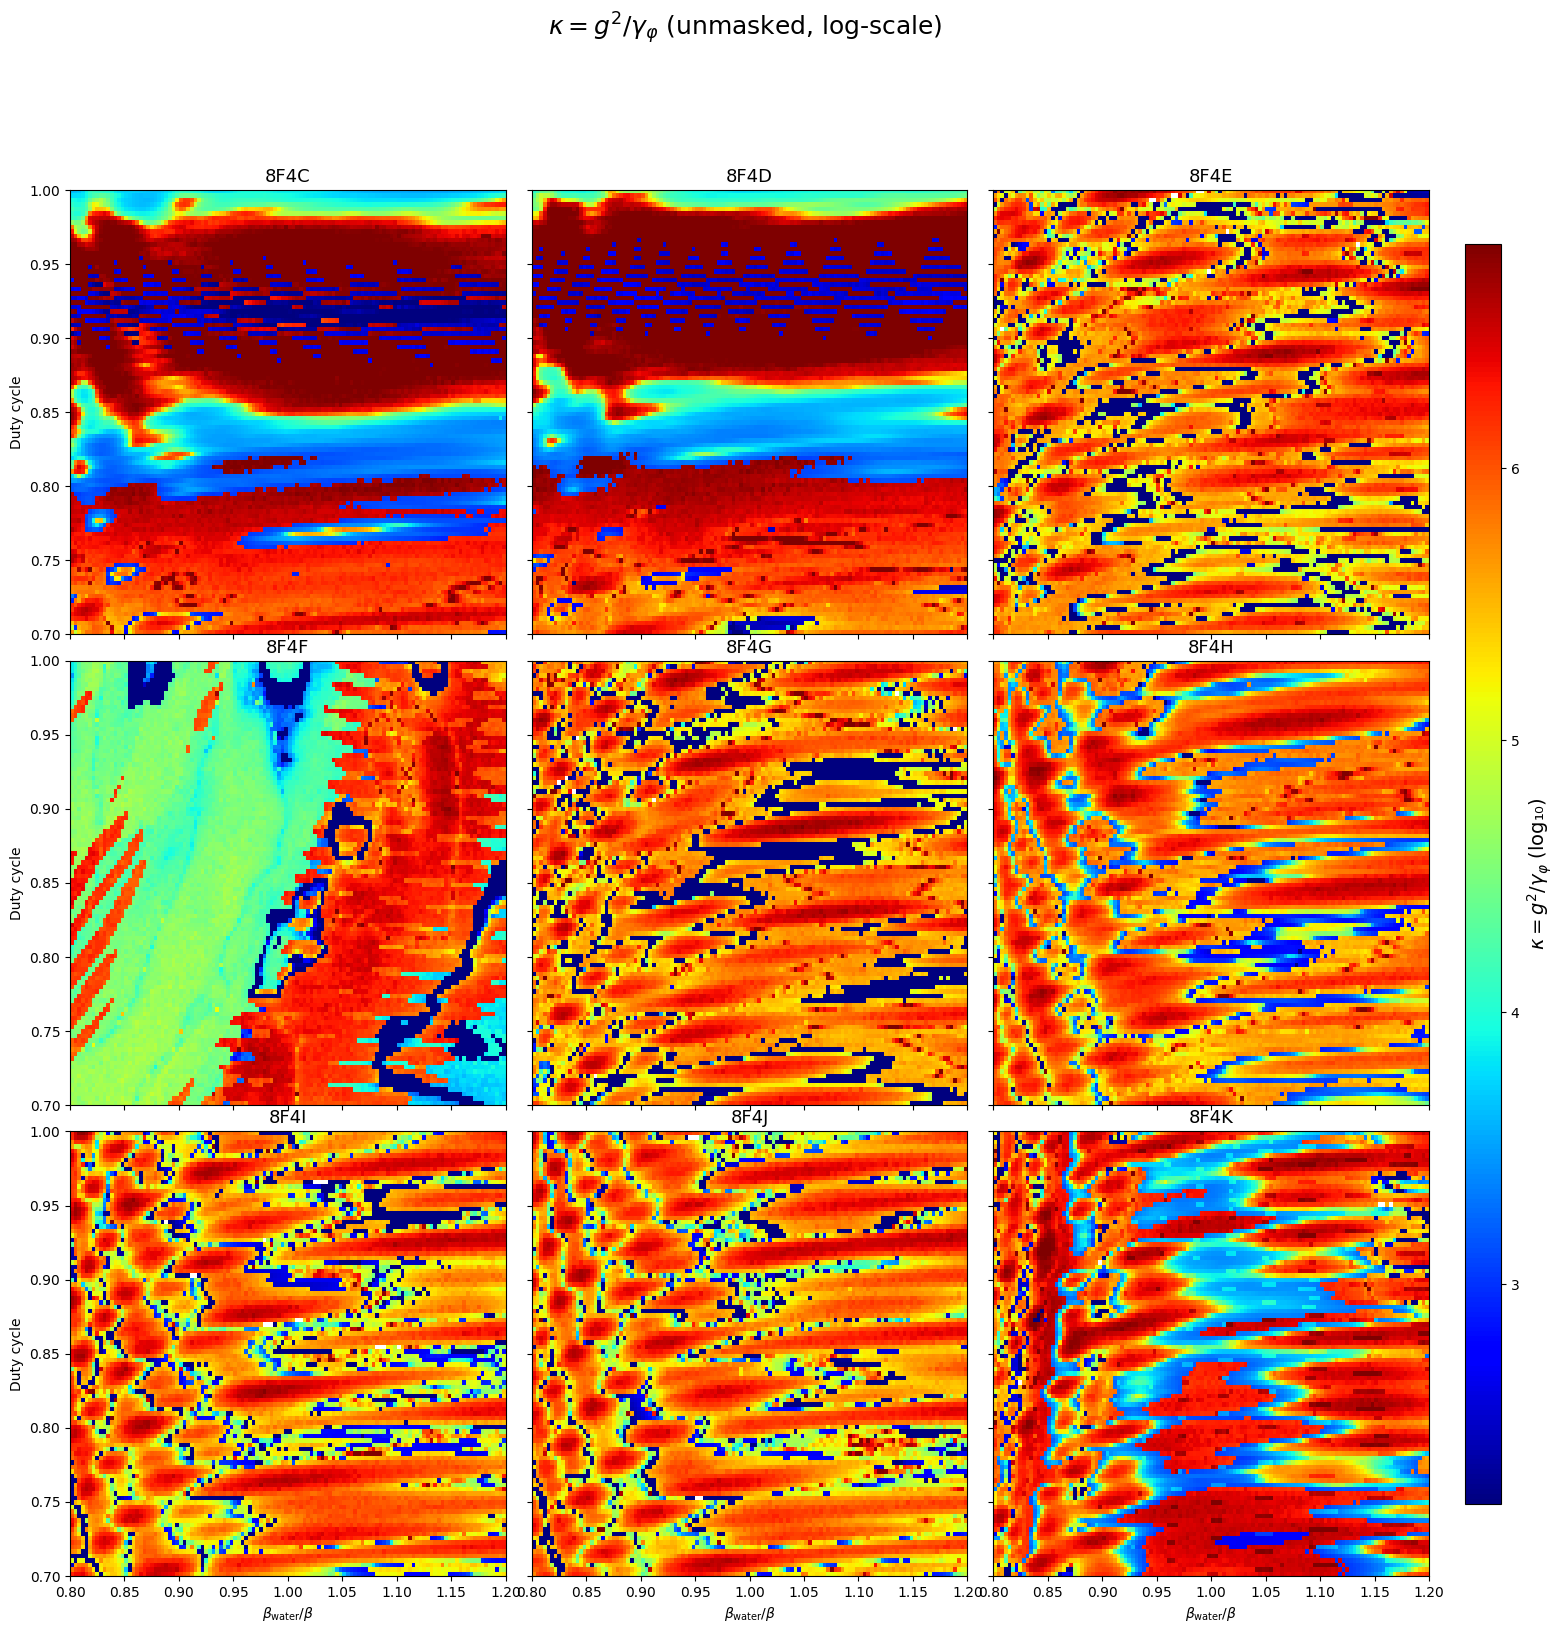

Saved: /content/dj_maps/Composite_LOG10_kappa_unmasked.png


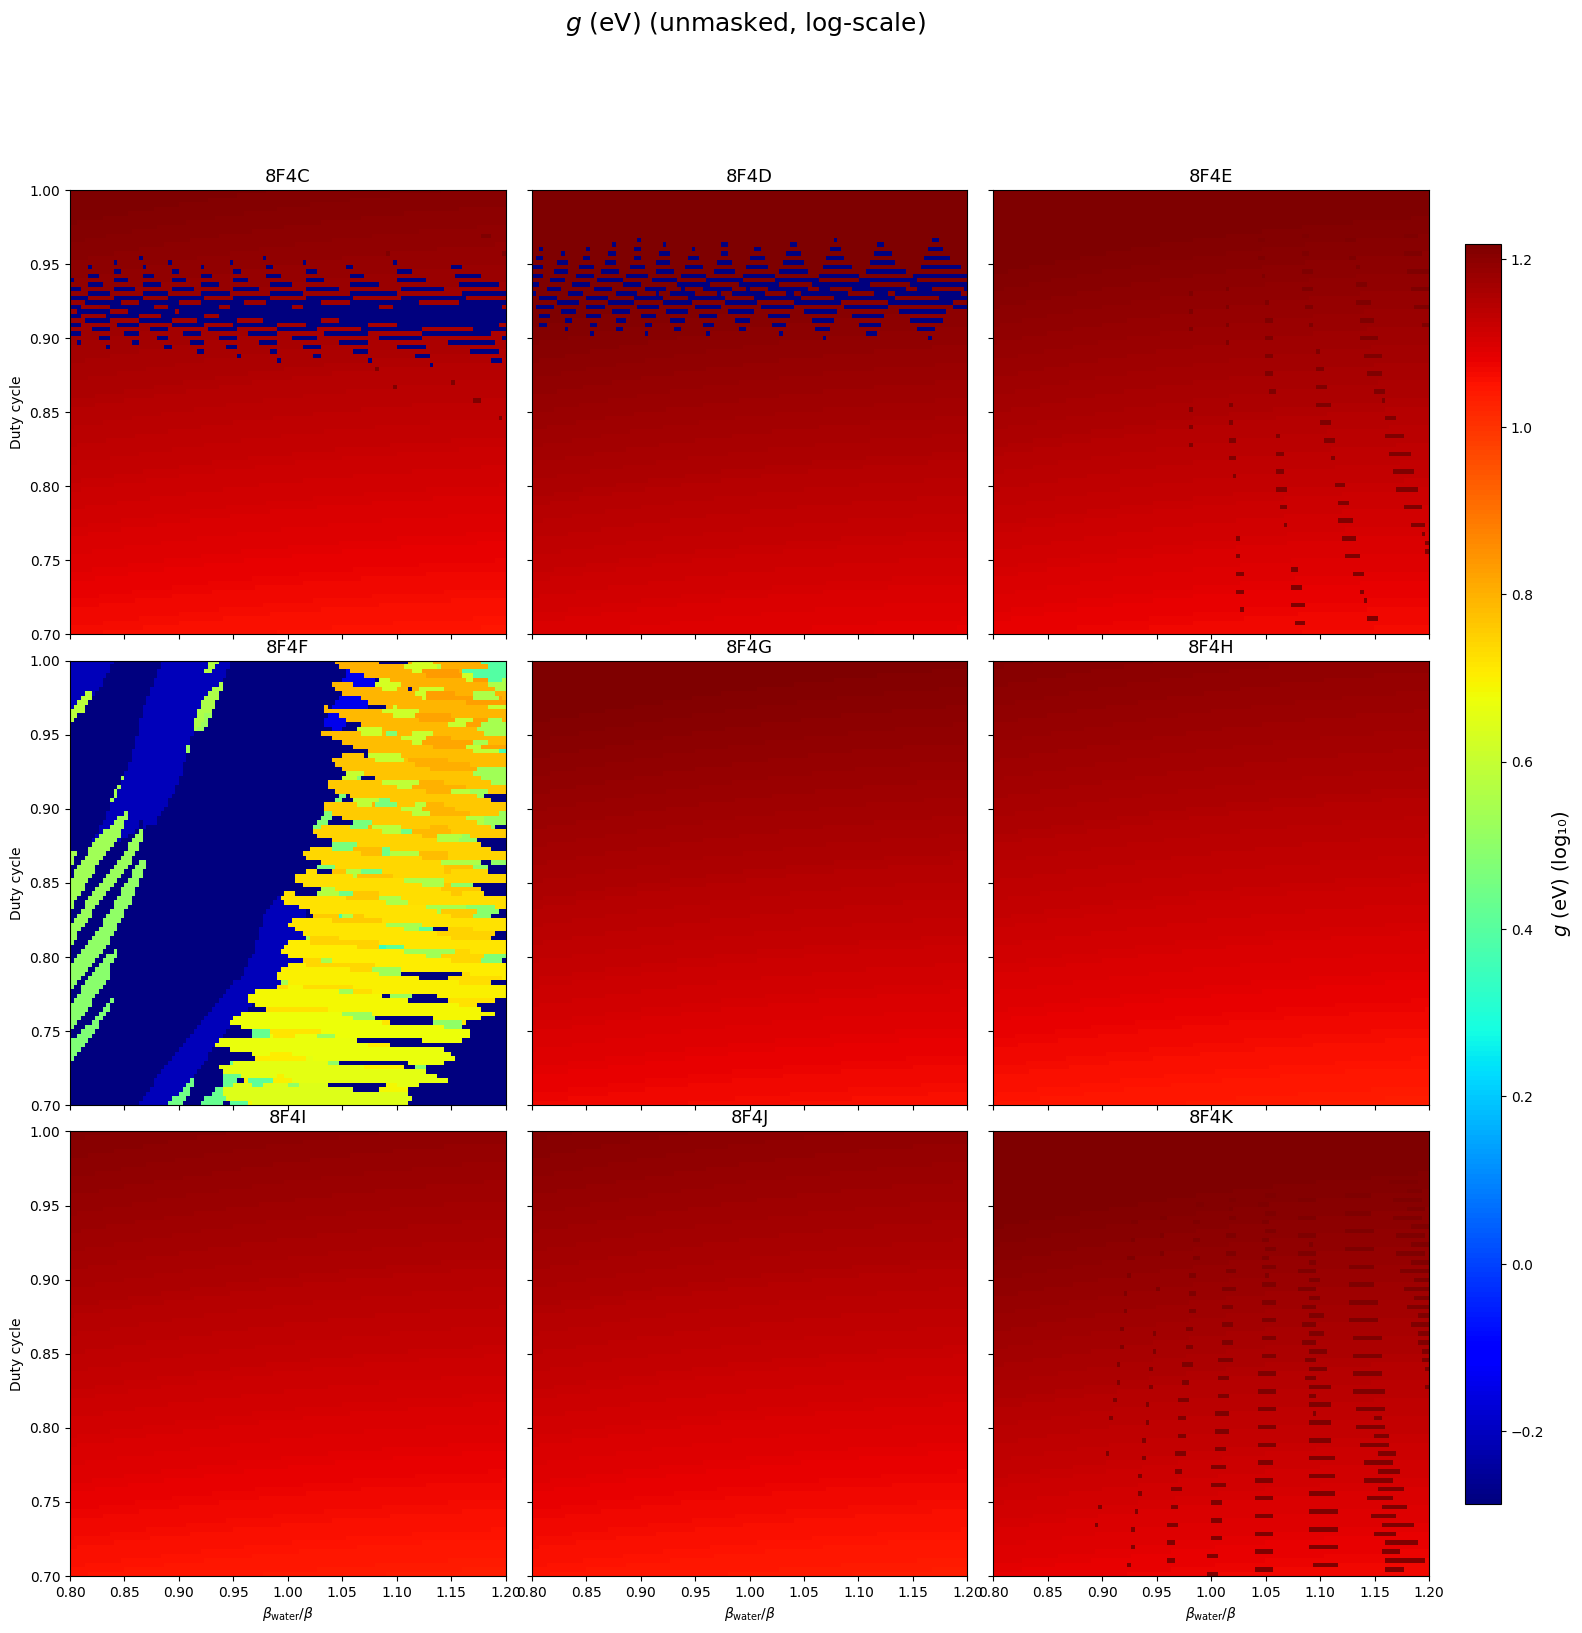

Saved: /content/dj_maps/Composite_LOG10_g_unmasked.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- directories & structures ----
base_dir = Path("/content/dj_maps")
STRUCTURES = [
    "8F4C","8F4D","8F4E",
    "8F4F","8F4G","8F4H",
    "8F4I","8F4J","8F4K",
]

# ---- load grids ----
g_all, gamma_all, Q_all, K_all = {}, {}, {}, {}
duties, betas = None, None

for s in STRUCTURES:
    dat = np.load(base_dir / f"DJ_{s}_wow.npz")
    if duties is None:
        duties = dat["duties"]
        betas  = dat["betas"]

    g_all[s]     = dat["g_grid"]
    gamma_all[s] = dat["gamma_grid"]
    Q_all[s]     = dat["Q_grid"]
    K_all[s]     = dat["kappa_grid"]

extent = [betas[0], betas[-1], duties[0], duties[-1]]

# ------------------------------------------------------
# Helper: log-scale composite (no masking)
# ------------------------------------------------------
def composite_log_unmasked(grid_dict, title, fname):

    # get global values to scale logs
    vals = np.hstack([
        grid_dict[s][np.isfinite(grid_dict[s]) & (grid_dict[s] > 0)]
        for s in STRUCTURES
    ])
    vmin = np.nanpercentile(vals, 5)
    vmax = np.nanpercentile(vals, 95)

    lvmin = np.log10(vmin)
    lvmax = np.log10(vmax)

    fig, axes = plt.subplots(3, 3, figsize=(18, 18),
                             sharex=True, sharey=True)
    fig.subplots_adjust(right=0.88, wspace=0.06, hspace=0.06)

    for k, s in enumerate(STRUCTURES):
        r, c = k//3, k%3
        ax = axes[r, c]
        raw  = grid_dict[s]
        logg = np.full_like(raw, np.nan)
        mask = (raw > 0) & np.isfinite(raw)
        logg[mask] = np.log10(raw[mask])

        im = ax.imshow(
            logg, origin="lower", extent=extent,
            cmap="jet", interpolation="nearest", aspect="auto",
            vmin=lvmin, vmax=lvmax
        )

        ax.set_title(s, fontsize=13)
        if r == 2: ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        if c == 0: ax.set_ylabel("Duty cycle")

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(title + " (log₁₀)", fontsize=14)

    fig.suptitle(title + " (unmasked, log-scale)", fontsize=18)

    fig.savefig(base_dir / f"{fname}.png", dpi=600)
    fig.savefig(base_dir / f"{fname}.pdf")

    plt.show()
    print("Saved:", base_dir / f"{fname}.png")


# ------------------------------------------------------
# Draw & save the three unmasked log composites
# ------------------------------------------------------

# 1) log10(Q)
composite_log_unmasked(
    Q_all,
    r"$Q = g/\gamma_{\varphi}$",
    "Composite_LOG10_Q_unmasked"
)

# 2) log10(kappa)
composite_log_unmasked(
    K_all,
    r"$\kappa = g^2/\gamma_{\varphi}$",
    "Composite_LOG10_kappa_unmasked"
)

# 3) log10(g)
composite_log_unmasked(
    g_all,
    r"$g$ (eV)",
    "Composite_LOG10_g_unmasked"
)

In [ ]:
# ============================================================
#  Regenerate DJ_{s}_wow.npz WITH g, gamma, Q, kappa
#  for alternative PSII structures: 3WU2, 6W1U, 6W1V, 7RF1, 8F4K, 8EZ5
#  (reuses the same TDSE engine: read_structure_any, get_psii_core_16, run_tdse_camn)
# ============================================================

import numpy as np
from pathlib import Path
import shutil

# Alt + some key 8F4 states for comparison (optional)
STRUCTURES = [
    "3WU2", "6W1U", "6W1V", "7RF1", "8EZ5",
    "8F4C", "8F4D", "8F4E", "8F4F", "8F4G", "8F4H", "8F4I", "8F4J", "8F4K",
]

base_dir      = Path("/content/dj_maps")
CONTENT_ROOT  = Path("/content")
CIF_DIR       = Path("/content/drive/MyDrive/psii_cifs")  # where you mirror CIFs

CIF_DIR.mkdir(parents=True, exist_ok=True)
base_dir.mkdir(parents=True, exist_ok=True)

# Reuse the same duties/betas from an existing NPZ
sample_npz = np.load(base_dir / "DJ_8F4C_wow.npz")
duties = sample_npz["duties"]
betas  = sample_npz["betas"]

def find_cif(struct):
    cif_name = f"{struct}.cif"
    cif_ct   = CONTENT_ROOT / cif_name
    cif_dr   = CIF_DIR / cif_name
    if cif_ct.exists():
        if not cif_dr.exists():
            shutil.copy2(cif_ct, cif_dr)
        return cif_ct
    if cif_dr.exists():
        return cif_dr
    raise FileNotFoundError(f"CIF for {struct} not found in {CONTENT_ROOT} or {CIF_DIR}")

for s in STRUCTURES:
    print(f"\nRebuilding DJ_{s}_wow.npz ...")

    cif_path = find_cif(s)
    st = read_structure_any(cif_path)
    coords, labels = get_psii_core_16(st)

    n_d, n_b = len(duties), len(betas)

    g_grid     = np.zeros((n_d, n_b))
    gamma_grid = np.zeros((n_d, n_b))
    Q_grid     = np.zeros((n_d, n_b))
    kappa_grid = np.zeros((n_d, n_b))

    for i, duty in enumerate(duties):
        print(f"  {s}: row {i+1}/{n_d} (duty={duty:.3f})")
        for j, beta_scale in enumerate(betas):
            g_val, gamma_val = run_tdse_camn(coords, labels, duty, beta_scale)
            g_grid[i, j]     = g_val
            gamma_grid[i, j] = gamma_val
            if np.isfinite(g_val) and (gamma_val is not None) and (gamma_val > 0):
                Q_grid[i, j]     = g_val / gamma_val
                kappa_grid[i, j] = (g_val**2) / gamma_val
            else:
                Q_grid[i, j]     = np.nan
                kappa_grid[i, j] = np.nan

    npz_path = base_dir / f"DJ_{s}_wow.npz"
    np.savez(
        npz_path,
        duties=duties,
        betas=betas,
        g_grid=g_grid,
        gamma_grid=gamma_grid,
        Q_grid=Q_grid,
        kappa_grid=kappa_grid,
    )

    print(f"  Saved full DJ_{s}_wow.npz with g, gamma, Q, kappa.")


Rebuilding DJ_3WU2_wow.npz ...
  3WU2: row 1/100 (duty=0.700)
  3WU2: row 2/100 (duty=0.703)
  3WU2: row 3/100 (duty=0.706)
  3WU2: row 4/100 (duty=0.709)
  3WU2: row 5/100 (duty=0.712)
  3WU2: row 6/100 (duty=0.715)
  3WU2: row 7/100 (duty=0.718)
  3WU2: row 8/100 (duty=0.721)
  3WU2: row 9/100 (duty=0.724)
  3WU2: row 10/100 (duty=0.727)
  3WU2: row 11/100 (duty=0.730)
  3WU2: row 12/100 (duty=0.733)
  3WU2: row 13/100 (duty=0.736)
  3WU2: row 14/100 (duty=0.739)
  3WU2: row 15/100 (duty=0.742)
  3WU2: row 16/100 (duty=0.745)
  3WU2: row 17/100 (duty=0.748)
  3WU2: row 18/100 (duty=0.752)
  3WU2: row 19/100 (duty=0.755)
  3WU2: row 20/100 (duty=0.758)
  3WU2: row 21/100 (duty=0.761)
  3WU2: row 22/100 (duty=0.764)
  3WU2: row 23/100 (duty=0.767)
  3WU2: row 24/100 (duty=0.770)
  3WU2: row 25/100 (duty=0.773)
  3WU2: row 26/100 (duty=0.776)
  3WU2: row 27/100 (duty=0.779)
  3WU2: row 28/100 (duty=0.782)
  3WU2: row 29/100 (duty=0.785)
  3WU2: row 30/100 (duty=0.788)
  3WU2: row 31/10

In [ ]:
import shutil

shutil.make_archive("/content/dj_maps_alt_3WU2_8F4K", "zip", "/content/dj_maps")

'/content/dj_maps_alt_3WU2_8F4K.zip'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("/content/dj_maps")

STRUCTURES = [
    "3WU2", "6W1U", "6W1V", "7RF1", "8EZ5",
    "8F4C", "8F4K",
]

out_dir = base_dir / "png_single"
out_dir.mkdir(parents=True, exist_ok=True)

def plot_single_g_map(struct_name):
    npz_path = base_dir / f"DJ_{struct_name}_wow.npz"
    if not npz_path.exists():
        print(f"Missing {npz_path}")
        return

    data = np.load(npz_path)
    duties = data["duties"]
    betas  = data["betas"]
    g_grid = data["g_grid"]

    x_min, x_max = float(betas.min()), float(betas.max())
    y_min, y_max = float(duties.min()), float(duties.max())

    plt.figure(figsize=(6,5), dpi=150)
    im = plt.imshow(
        g_grid,
        origin="lower",
        aspect="auto",
        extent=[x_min, x_max, y_min, y_max],
        cmap="jet"
    )
    cbar = plt.colorbar(im)
    cbar.set_label("g (eV)")
    plt.xlabel(r"$\beta_{\mathrm{water}} / \beta$")
    plt.ylabel("duty")
    plt.title(f"DJ_{struct_name}_wow: g")

    plt.tight_layout()
    out_path = out_dir / f"DJ_{struct_name}_wow_g.png"
    plt.savefig(out_path, dpi=150)
    plt.close()

    print(f"Saved {out_path}")

for s in STRUCTURES:
    plot_single_g_map(s)

Saved /content/dj_maps/png_single/DJ_3WU2_wow_g.png
Saved /content/dj_maps/png_single/DJ_6W1U_wow_g.png
Saved /content/dj_maps/png_single/DJ_6W1V_wow_g.png
Saved /content/dj_maps/png_single/DJ_7RF1_wow_g.png
Saved /content/dj_maps/png_single/DJ_8EZ5_wow_g.png
Saved /content/dj_maps/png_single/DJ_8F4C_wow_g.png
Saved /content/dj_maps/png_single/DJ_8F4K_wow_g.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("/content/dj_maps")

# 3×3 layout matching your earlier figure:
# top:    3WU2, 6W1U, 6W1V
# middle: 7RF1, 8EZ5, 8F4C
# bottom: 8F4F, 8F4G, 8F4K
struct_grid = [
    ["3WU2", "6W1U", "6W1V"],
    ["7RF1", "8EZ5", "8F4C"],
    ["8F4F", "8F4G", "8F4K"],
]

# First pass: load all kappa grids to find global vmin/vmax
kappa_data = {}
global_min = None
global_max = None
duties_ref = None
betas_ref = None

for row in struct_grid:
    for s in row:
        npz_path = base_dir / f"DJ_{s}_wow.npz"
        if not npz_path.exists():
            print(f"WARNING: {npz_path} not found, skipping {s}")
            continue

        data = np.load(npz_path)
        duties = data["duties"]
        betas  = data["betas"]
        kappa  = data["kappa_grid"]

        # Store for later plotting
        kappa_data[s] = (duties, betas, kappa)

        # Use finite entries only for color scale
        finite_vals = kappa[np.isfinite(kappa)]
        if finite_vals.size > 0:
            kmin = float(finite_vals.min())
            kmax = float(finite_vals.max())
            if global_min is None or kmin < global_min:
                global_min = kmin
            if global_max is None or kmax > global_max:
                global_max = kmax

        # Keep a reference duties/betas (assumed same grid)
        if duties_ref is None:
            duties_ref = duties
        if betas_ref is None:
            betas_ref = betas

# Safety check on color scale
if global_min is None or global_max is None:
    raise RuntimeError("No finite kappa values found; cannot build composite.")

x_min, x_max = float(betas_ref.min()), float(betas_ref.max())
y_min, y_max = float(duties_ref.min()), float(duties_ref.max())

fig, axes = plt.subplots(3, 3, figsize=(9, 9), dpi=150)

for i, row in enumerate(struct_grid):
    for j, s in enumerate(row):
        ax = axes[i, j]
        if s not in kappa_data:
            ax.set_axis_off()
            continue

        duties, betas, kappa = kappa_data[s]

        im = ax.imshow(
            kappa,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, y_min, y_max],
            cmap="jet",
            vmin=global_min,
            vmax=global_max,
        )
        ax.set_title(s, fontsize=10)
        if i == 2:  # bottom row: x-labels
            ax.set_xlabel(r"$\beta_{\mathrm{water}} / \beta$", fontsize=9)
        else:
            ax.set_xticklabels([])
        if j == 0:  # left column: y-labels
            ax.set_ylabel("duty", fontsize=9)
        else:
            ax.set_yticklabels([])

fig.tight_layout()

# Shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label(r"$\kappa = g^2 / \gamma_{\varphi}$", fontsize=10)

out_path = base_dir / "Composite_kappa_3x3.png"
fig.savefig(out_path, dpi=150)
plt.close(fig)

print(f"Saved composite kappa figure to {out_path}")

Saved composite kappa figure to /content/dj_maps/Composite_kappa_3x3.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("/content/dj_maps")

struct_grid = [
    ["3WU2", "6W1U", "6W1V"],
    ["7RF1", "8EZ5", "8F4C"],
    ["8F4F", "8F4G", "8F4K"],
]

kappa_log_data = {}
all_log_vals = []
duties_ref = None
betas_ref = None

for row in struct_grid:
    for s in row:
        npz_path = base_dir / f"DJ_{s}_wow.npz"
        data = np.load(npz_path)
        duties = data["duties"]
        betas  = data["betas"]
        kappa  = data["kappa_grid"]

        # log10(kappa), mask non-positive or non-finite
        kappa_log = np.full_like(kappa, np.nan, dtype=float)
        mask = np.isfinite(kappa) & (kappa > 0)
        kappa_log[mask] = np.log10(kappa[mask])

        kappa_log_data[s] = (duties, betas, kappa_log)

        if duties_ref is None:
            duties_ref = duties
            betas_ref  = betas

        finite_log = kappa_log[np.isfinite(kappa_log)]
        if finite_log.size > 0:
            all_log_vals.append(finite_log)

# global color scale in log-space (clip extremes)
all_log_vals = np.concatenate(all_log_vals)
vmin = np.percentile(all_log_vals, 5)   # lower 5%
vmax = np.percentile(all_log_vals, 95)  # upper 95%

print("Using log10(kappa) range:", vmin, vmax)

x_min, x_max = float(betas_ref.min()), float(betas_ref.max())
y_min, y_max = float(duties_ref.min()), float(duties_ref.max())

fig, axes = plt.subplots(3, 3, figsize=(9, 9), dpi=150)

for i, row in enumerate(struct_grid):
    for j, s in enumerate(row):
        ax = axes[i, j]
        duties, betas, kappa_log = kappa_log_data[s]

        im = ax.imshow(
            kappa_log,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, y_min, y_max],
            cmap="jet",
            vmin=vmin,
            vmax=vmax,
        )

        ax.set_title(s, fontsize=10)
        if i == 2:
            ax.set_xlabel(r"$\beta_{\mathrm{water}} / \beta$")
        else:
            ax.set_xticklabels([])
        if j == 0:
            ax.set_ylabel("duty")
        else:
            ax.set_yticklabels([])

fig.tight_layout()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label(r"$\log_{10}\,\kappa$")

out_path = base_dir / "Composite_LOG10_kappa_3x3.png"
fig.savefig(out_path, dpi=150)
plt.close(fig)

print("Saved:", out_path)

Using log10(kappa) range: 1.380953112395041 6.650757752714995
Saved: /content/dj_maps/Composite_LOG10_kappa_3x3.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("/content/dj_maps")

struct_grid = [
    ["3WU2", "6W1U", "6W1V"],
    ["7RF1", "8EZ5", "8F4C"],
    ["8F4F", "8F4G", "8F4K"],
]

Q_log_data = {}
all_log_vals = []
duties_ref = None
betas_ref = None

# Load Q for all structures and precompute log10(Q)
for row in struct_grid:
    for s in row:
        npz_path = base_dir / f"DJ_{s}_wow.npz"
        data = np.load(npz_path)
        duties = data["duties"]
        betas  = data["betas"]
        Q      = data["Q_grid"]

        # log10(Q) with masking for <=0 or NaN
        Q_log = np.full_like(Q, np.nan, dtype=float)
        mask = np.isfinite(Q) & (Q > 0)
        Q_log[mask] = np.log10(Q[mask])

        Q_log_data[s] = (duties, betas, Q_log)

        if duties_ref is None:
            duties_ref = duties
            betas_ref  = betas

        finite_log = Q_log[np.isfinite(Q_log)]
        if finite_log.size > 0:
            all_log_vals.append(finite_log)

# global percentile-based color scale
all_log_vals = np.concatenate(all_log_vals)
vmin = np.percentile(all_log_vals, 5)
vmax = np.percentile(all_log_vals, 95)

print("Using log10(Q) range:", vmin, vmax)

# axis extents
x_min, x_max = float(betas_ref.min()), float(betas_ref.max())
y_min, y_max = float(duties_ref.min()), float(duties_ref.max())

fig, axes = plt.subplots(3, 3, figsize=(9, 9), dpi=150)

# plotting loop
for i, row in enumerate(struct_grid):
    for j, s in enumerate(row):
        ax = axes[i, j]
        duties, betas, Q_log = Q_log_data[s]

        im = ax.imshow(
            Q_log,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, y_min, y_max],
            cmap="jet",
            vmin=vmin,
            vmax=vmax,
        )

        ax.set_title(s, fontsize=10)
        if i == 2:
            ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
        else:
            ax.set_xticklabels([])
        if j == 0:
            ax.set_ylabel("duty")
        else:
            ax.set_yticklabels([])

fig.tight_layout()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label(r"$\log_{10} Q$")

out_path = base_dir / "Composite_LOG10_Q_3x3.png"
fig.savefig(out_path, dpi=150)
plt.close(fig)

print("Saved:", out_path)

Using log10(Q) range: 0.32267697887493674 5.669941909588822
Saved: /content/dj_maps/Composite_LOG10_Q_3x3.png
